In [ ]:
from pandas_datareader import data as web
import os
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import csv
from matplotlib import pyplot as plt
import random
import plotly.colors
from datetime import datetime
import time
import datetime as dt
import copy
import glob
import pickle

In [ ]:
def get_data(asset_name='SPY', directory=os.path.join('..','..','data','yahoo_data'), start_date='01-01-2005', stop_date='12-20-2019', force_yahoo=0, verbosity=0):
        
    # If the 'directory' doesn't exist, create it
    if os.path.isdir(directory) == False:
        os.mkdir(directory)

    pathname = directory + '/' + asset_name + '_' + start_date + '.csv'
    if os.path.isfile(pathname) == True and not force_yahoo:
        if verbosity >= 1:
            print('Loading from file: ', pathname)        
        df = pd.read_csv(pathname, index_col='Date')
    else:
        if verbosity >= 1:
            print('Downloading from Yahoo! - ', asset_name)
        df = web.DataReader(asset_name, data_source='yahoo', start=start_date, end=stop_date)
        df.to_csv(pathname)    

    # Copy the (date) index to a Date field and make a new index which enumerates
    # all the entries.
    df.insert(0, 'Date', df.index)
    df.index = np.arange(df.shape[0])
    df['Date']=pd.to_datetime(df['Date'], format='%Y/%m/%d')
    
    return df 

In [ ]:
# Synthetic stock generator

# We'll generate the Adj Close price as the primary (since this is the sequnce of labels we are training on)
# The relationship of the other features to the Adj Close will be as follows:
# Close = close_scale * Adj Close
# Open = previous day's Close
# Low = Open
# High = Close
# Volume = 0

# source_asset_name - name of asset to model from
# trend_list - list of tuples - (magnitude, days for a full cycle of this trend)

def make_synthetic_stock(source_asset_name='SPY', new_name='SYN', directory=os.path.join('..','..','data','yahoo_data'), start_date='01-01-2005', stop_date='12-20-2019', trend_list=[], adj_close_start=0, price_slope=0, close_scale=1.4):
    
    syn_df = get_data(asset_name=source_asset_name, directory=directory, start_date=start_date, stop_date=stop_date, force_yahoo=1)
        
    syn_length = len(syn_df)
    
    for i in range(syn_length):
        mag = adj_close_start + (i * price_slope)
        for trend in trend_list:
            mag += (trend[0] * np.sin(6.28 * i / trend[1]))

        syn_df['Adj Close'].loc[i] = mag
        syn_df['Close'].loc[i] = mag * close_scale
    
        # Today's open is yesterday's close
        if i > 0:
            syn_df['Open'].loc[i] = syn_df['Close'].loc[i-1]
        else:
            syn_df['Open'].loc[i] = syn_df['Close'].loc[i]
        
        syn_df['Low'].loc[i] = syn_df['Open'].loc[i]
        syn_df['High'].loc[i] = syn_df['Close'].loc[i]
    
    pathname = directory + '/' + new_name + '_' + start_date + '.csv'    
    
    syn_df.to_csv(pathname, index=False)    

    

In [ ]:
# Display a Plotly interactive candelstick chart

# path is directory to save image in
# display_plot - 1=display plot in Notebook

def plotly_candlestick(asset_df, asset_name, basefn = '', display_plot = 0, save_plot=1):

    df = asset_df
    
    trace1 = {
        'x': df.Date,
        'open': df.Open,
        'close': df.Close,
        'high': df.High,
        'low': df.Low,
        'type': 'candlestick',
        'name': asset_name,
        'showlegend': True
    }

    data = [trace1]
        
    layout = go.Layout({
        'title': {
            'text': 'Asset: ' + asset_name,
            'font': {
                'size': 20
            }
        }
    })

    fig = go.Figure(trace1, layout)
    
    if display_plot:        
        fig.show()
    
    if save_plot:
        fig.write_html(basefn + 'asset_candelstick.html')



In [ ]:
def add_features_to_df(df):
    # Add a feature called Prev Adj CLose
    prev_adj_close = df['Adj Close'].shift(1).copy()
    df['Prev Adj Close'] = prev_adj_close

    # Take care of special case of very first previous Adj close - just make is the same as the Adj Close
    df['Prev Adj Close'][0] = df['Prev Adj Close'][1]
    
    # Volume isn't used
    df = df.drop(columns=['Volume'])
    
    return df
    

In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

print("Cuda available:",torch.cuda.is_available())

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    


In [ ]:
# This will normalise each column of a dataframe to +/- 0.5

def normalise_df(df):
           
    r = df.copy()
    
    # Get the min and max of all values in dataframe except 'Date' field
    min_value = df.drop('Date',1).min().min()    
    max_value = df.drop('Date',1).max().max()

#    print(min_value)
#    print(max_value)
    
#    r['Open'] = (r['Open'] - min_value) / (max_value - min_value) - 0.5
#    r['Low'] = (r['Low'] - min_value) / (max_value - min_value) - 0.5
#    r['High'] = (r['High'] - min_value) / (max_value - min_value) - 0.5
#    r['Close'] = (r['Close'] - min_value) / (max_value - min_value) - 0.5
#    r['Adj Close'] = (r['Adj Close'] - min_value) / (max_value - min_value) - 0.5
#    r['Prev Adj Close'] = (r['Prev Adj Close'] - min_value) / (max_value - min_value) - 0.5    


    r.loc[:, r.columns != 'Date'] = (((r.loc[:, r.columns != 'Date'] - min_value) / (max_value - min_value)) - 0.5)
#    print(r.describe())
    
#    display(r)
    scale = max_value - min_value
    offset = min_value
#    To un-normalise:
    
#    original_value = ((norm_price + 0.5) * scale) + offset
#    scale = max_value - min_value
#    offset = min_value

#    print("values from df normalisation:")
#    print("Scale:", scale)
#    print("Offset:", offset)


#    display(r.head())
#    display(df.head())
    return r, scale, offset

In [ ]:
def denormalise_value(norm_value, scale, offset):
    return (((norm_value + 0.5) * scale) + offset)

In [ ]:
def unnormalise_df(df, scale, offset):
    
    result = df.copy()
    
    df = ((df + 0.5) * scale) + offset
    
    return(df)

In [ ]:
# This version is for sequence to value learning - the label is a single value - tomorrow's Adj Close

# Given one of the asset train, valid or test dataframes, this will make a new three dimensional list which has
# dimensions (num_samples, window_size - tw, 6) which represents the effect of sliding a window of width window_size (tw)
# down the dataframe from start to end and collecting the input features into a length 6 vector.  This will be our
# input dataset to the LSTM.

# In addition, also generate a list of (training) labels which is "tomorrow's" adjusted closing price - the thing 
# we are trying to predict. There is a single training label for each tw x 6 set of inputs.


def create_input_sequences_out_val_from_df(input_data_df, tw):
    in_seq = []
    out_seq= []
    L = len(input_data_df)

    for i in range(L-tw):
        seq = []
        for j in range(tw):
            features = [input_data_df['Open'].loc[i+j], input_data_df['Low'].loc[i+j], input_data_df['High'].loc[i+j], 
                        input_data_df['Close'].loc[i+j], 
                         input_data_df['Prev Adj Close'].loc[i+j], input_data_df['Adj Close'].loc[i+j]]
            seq.append(features)

        train_label = input_data_df['Adj Close'].loc[i+tw]
        out_seq.append(train_label)
        in_seq.append(seq)
    return in_seq, out_seq


In [ ]:
# This version is for sequence to sequence learning - the label is a sequence up to and including tomorrows Adj Close

def create_input_sequences_from_df(input_data_df, tw):
    in_seq = []
    out_seq= []
    L = len(input_data_df)

    for i in range(L-tw):
        window_input_seq = []
        window_output_seq = []
        for j in range(tw):
            features = [input_data_df['Open'].loc[i+j], input_data_df['Low'].loc[i+j], input_data_df['High'].loc[i+j], 
                        input_data_df['Close'].loc[i+j], 
                         input_data_df['Prev Adj Close'].loc[i+j], input_data_df['Adj Close'].loc[i+j]]
            window_input_seq.append(features)
            
            window_output_seq.append(input_data_df['Adj Close'].loc[i+j+1])

        out_seq.append(window_output_seq)
        in_seq.append(window_input_seq)
        
#        print("seq:", i)
#        print("input:\n",window_input_seq)
#        print("output:\n", window_output_seq)
    return in_seq, out_seq


In [ ]:
def get_continuous_color(colorscale, intermed):
    """
    Plotly continuous colorscales assign colors to the range [0, 1]. This function computes the intermediate
    color for any value in that range.

    Plotly doesn't make the colorscales directly accessible in a common format.
    Some are ready to use:
    
        colorscale = plotly.colors.PLOTLY_SCALES["Greens"]

    Others are just swatches that need to be constructed into a colorscale:

        viridis_colors, scale = plotly.colors.convert_colors_to_same_type(plotly.colors.sequential.Viridis)
        colorscale = plotly.colors.make_colorscale(viridis_colors, scale=scale)

    :param colorscale: A plotly continuous colorscale defined with RGB string colors.
    :param intermed: value in the range [0, 1]
    :return: color in rgb string format
    :rtype: str
    """
    if len(colorscale) < 1:
        raise ValueError("colorscale must have at least one color")

    if intermed <= 0 or len(colorscale) == 1:
        return colorscale[0][1]
    if intermed >= 1:
        return colorscale[-1][1]

    for cutoff, color in colorscale:
        if intermed >= cutoff:
            low_cutoff, low_color = cutoff, color
        else:
            high_cutoff, high_color = cutoff, color
            break

    # noinspection PyUnboundLocalVariable
    return plotly.colors.find_intermediate_color(
        lowcolor=low_color, highcolor=high_color,
        intermed=((intermed - low_cutoff) / (high_cutoff - low_cutoff)),
        colortype="rgb")

In [ ]:
def plotly_gradients(model, min_grads, max_grads, ave_grads, basefn='', display_plot=0, save_plot=1):
    
    scale = plotly.colors.PLOTLY_SCALES["Bluered"]

    print("Number of gradients randomly sampled:", len(ave_grads))  
    
    
    # Assemble the names of the layers
    layers = []
    for n,p in model.named_parameters():
        if (p.requires_grad) and ("bias" not in n):
            layers.append(n)
    
    # Dong this the dumb way just now
    max_array = np.zeros(len(layers))
    min_array = np.ones(len(layers))
    mean_array = np.zeros(len(layers))
    
    for i in range(len(min_grads)):
        for j in range(len(layers)):
            if max_grads[i][j].item() > max_array[j]:
                max_array[j] = max_grads[i][j].item()
            
            mean_array[j] += ave_grads[i][j].item()
            
            if min_grads[i][j].item() < min_array[j]:
                min_array[j] = min_grads[i][j].item()
                   
    mean_array /= len(min_grads)
    
    print(len(layers))
    print(len(min_grads))
    print(len(max_grads))
    print(len(ave_grads))    

    print(min_array)
    print(mean_array)
    print(max_array)
    
    fig = go.Figure()
    df = pd.DataFrame(
#        {'mean': [0.1,0.4,0.5,0.6,0.7,0.8,0.9],
#        'max': [0.3,0.5,0.6,0.9,1.1,1.3,1.6],
#        'min': [0.0,0.2,0.4,0.3,0.5,0.2,0.3],
        {'mean': mean_array,
        'max': max_array,
        'min': min_array,         
        'labels': layers})

    fig.add_trace(go.Scatter(x=df['labels'], y=df['min'],
        fill=None,
        mode='lines',
        line_color=get_continuous_color(scale, 0),
        name="Min",
        line={'width': 4},
        legendgroup="group1"
        ))
    fig.add_trace(go.Scatter(
        x=df['labels'],
        y=df['mean'],
        legendgroup="group2",
        fill='tonexty',
        fillcolor=get_continuous_color(scale, 0.25).replace('rgb','rgba').replace(')',',0.5)'),
        line_color=get_continuous_color(scale, 0.25),
        mode='lines', name="Bottom Half"))
    fig.add_trace(go.Scatter(x=df['labels'], y=df['mean'],
        fill=None,
        mode='lines',
        legendgroup="group1",
        line={'width': 4},
        line_color=get_continuous_color(scale, 0.5),
        name="Mean"))
    fig.add_trace(go.Scatter(
        x=df['labels'],
        y=df['max'],
        legendgroup="group2",
        fill='tonexty',
        fillcolor=get_continuous_color(scale, 0.75).replace('rgb','rgba').replace(')',',0.5)'),
        line_color=get_continuous_color(scale, 0.75),
        mode='lines',
        name="Top Half"))
    fig.add_trace(go.Scatter(x=df['labels'], y=df['max'],
        fill=None,
        mode='lines',
        legendgroup="group1",
        line={'width': 4},
        line_color=get_continuous_color(scale, 1),
        name="Max"
        ))

    if display_plot:
        fig.show()
        
    if save_plot:
        fig.write_html(basefn + 'gradients.html')
    


In [ ]:
# train_loss and val_loss are lists containing the loss per step


def plot_losses(train_loss, val_loss, title='Train / Validation Loss', basefn='', display_plot=0, save_plot=1):

    iter = len(train_loss)
    
    # Plot the training / validation loss vs step
    trace1 = {
        'x': np.arange(0,len(train_loss)),
        'y': np.array(train_loss),
                  
        'type': 'scatter',
        'name': 'Training',
        'showlegend': True
    }

    trace2 = {
        'x': np.arange(0,len(val_loss)),
        'y': np.array(val_loss),
                  
        'type': 'scatter',
        'name': 'Validation',
        'showlegend': True
    }

    data = [trace1, trace2]
        
    layout = go.Layout({
        'title': {
            'text': title,
            'font': {
                'size': 20
            }
        }
    })

    fig = go.Figure(data, layout)
    
    if display_plot:
        fig.show()
        
    if save_plot:
        fig.write_html(basefn + 'Train_losses.html')
    



In [ ]:
def plot_returns_hist(predicted_returns, actual_returns, title='Histogram: Predicted vs Actual Returns', basefn='', display_plot=0, save_plot=1):

    fig = go.Figure()
    fig.add_trace(go.Histogram(x=predicted_returns, name='Predicted'))
    fig.add_trace(go.Histogram(x=actual_returns, name='Actual'))
    fig.update_layout(
        title_text = title,
        xaxis_title_text = 'Return',
        yaxis_title_text = 'Count'
    )
    
    if display_plot:
        fig.show()
    
    if save_plot:
        fig.write_html(basefn + 'Returns_hist.html')

In [ ]:
def plot_hidden(h, basefn='', display_plot=0, save_plot=1):
    
    # h is a tuple containing 2 tensors (one for h, one for c). 
    # Each tensor is of dimension [num layers, batch size, hidden size]
    # e.g. [3, 1, 128]
        
    titles = ['Hidden State', 'Cell State']
    
    x = np.arange(0, h[0].size()[2])
        
    # Loop through hidden and cell states
    for state in range(2):
        data = []
        # Loop through each layer, add a trace for each
        for layer in range(h[state].size()[0]):
            h_tensor = h[state][layer][0].cpu()
            trace = {
                'x': x,                
                'y': np.array(h_tensor.detach().numpy()),
                  
                'type': 'scatter',
                'name': 'Layer '+str(layer),
                'showlegend': True
                }
            data.append(trace)
        
        layout = go.Layout({
            'title': {
                'text': titles[state],
                'font': {
                    'size': 20
                }
            }
        })

        fig = go.Figure(data, layout)
        
        if display_plot:
            fig.show()
        
        if save_plot:
            fig.write_html(basefn + 'Train_hidden_layer_snapshot.html')


In [ ]:
def plot_lstm_output(lstm_output, basefn='', display_plot=0, save_plot=1):
    
    # lstm_output is a tuple containing [sequence length] number of tensors.
    # Each tensor is the lstm output with dimensions [batch size, hidden size]
    # e.g. [1, 128]
    
    x = np.arange(0, lstm_output.size()[1])
        
    data = []
    
    # Loop through each layer, add a trace for each
    for i in range(len(lstm_output)):
        lstm_tensor = lstm_output[i].cpu()
        trace = {
            'x': x,
            'y': np.array(lstm_tensor.detach().numpy()),
                  
            'type': 'scatter',
            'name': 'Cell '+str(i),
            'showlegend': True
            }
        data.append(trace)
        
    layout = go.Layout({
        'title': {
            'text': 'LSTM Output',
            'font': {
                'size': 20
            }
        }
    })

    fig = go.Figure(data, layout)
    
    if display_plot:
        fig.show()   
        
    if save_plot:
        fig.write_html(basefn + 'Train_LSTM_output_snapshot.html')
    

In [ ]:
def plot_weights(model, basefn='', display_plot=0, save_plot=1):
    
    # Plot the linear weights - just a simple line chart
    linear_tensor = model.linear.weight[0].cpu()
    x = np.arange(0, len(model.linear.weight[0]))
    y = np.array(linear_tensor.detach().numpy())
  
    # Plot the training / validation loss vs step
    trace1 = {
        'x': x,
        'y': y,
                  
        'type': 'scatter',
        'name': 'Linear Weights',
        'showlegend': True
    }

    data = [trace1]
        
    layout = go.Layout({
        'title': {
            'text': 'Linear Weights',
            'font': {
                'size': 20
            }
        }
    })

    fig = go.Figure(data, layout)
    
    if display_plot:
        fig.show()
        
    if save_plot:
        fig.write_html(basefn + 'Train_linear_weights.html')
    
    ave_weights = []
    max_weights = []
    layers = []
    for n,p in model.named_parameters():
        if (p.requires_grad) and ("bias" not in n) and ("linear" not in n):
            layers.append(n)
            ave_weights.append(p.abs().mean().item())
            max_weights.append(p.abs().max().item())

    trace1 = {
        'x' : layers,
        'y' : ave_weights,
        'type' : 'bar'
    }    

    data = [trace1]
    layout = go.Layout({
        'title': {
            'text': 'Average of LSTM Weights',
            'font': {
                'size': 20
            }
        }
    })

    fig = go.Figure(data, layout)

    if display_plot:
        fig.show()
        
    if save_plot:
        fig.write_html(basefn + 'Train_ave_lstm_weights.html')
    
    
    trace1 = {
        'x' : layers,
        'y' : max_weights,
        'type' : 'bar'
    }    

    data = [trace1]
    layout = go.Layout({
        'title': {
            'text': 'MAX of LSTM Weights',
            'font': {
                'size': 20
            }
        }
    })

    fig = go.Figure(data, layout)
    
    if display_plot:
        fig.show()
        
    if save_plot:
        fig.write_html(basefn + 'Train_max_lstm_weights.html')
        
    

In [ ]:
def gradient_plot(layer_names, grads, color, title, basefn='', display_plot=0, save_plot=1):
       
    for i in range(len(grads)):
        plt.plot(grads[i], alpha=0.3, color=color)
    
    plt.hlines(0, 0, len(grads)+1, linewidth=1, color="k")
    plt.xticks(range(0,len(grads[0]),1), layer_names, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(grads[0]))
    
    plt.xlabel("Layers")
    plt.ylabel("Gradient")
    plt.title(title)
    plt.grid(True)
           
    # This has to go before the plt.show() otherwise it's blank
    if save_plot:
        plt.savefig(basefn + title + '.png', bbox_inches='tight')

    if display_plot:
        plt.show()


In [ ]:
def plot_gradients(model, ave_grads, max_grads, basefn='', display_plot=0, save_plot=1):

    print("Number of gradients randomly sampled:", len(ave_grads))    
    
    # Assemble the names of the layers
    layers = []
    for n,p in model.named_parameters():
        if (p.requires_grad) and ("bias" not in n):
            layers.append(n)

    gradient_plot(layers, ave_grads, 'b', 'Gradient Flow - All Layers - Average', basefn=basefn, display_plot=display_plot, save_plot=save_plot)
    gradient_plot(layers, max_grads, 'r', 'Gradient Flow - All Layers - Max', basefn=basefn, display_plot=display_plot, save_plot=save_plot)
        
    ave_grads_lstm = [sublist[:len(layers)-1] for sublist in ave_grads]
    max_grads_lstm = [sublist[:len(layers)-1] for sublist in max_grads]
    layers_lstm = layers[0:len(layers)-1]
    
    gradient_plot(layers_lstm, ave_grads_lstm, 'b', 'Gradient Flow - LSTM Layers - Average', basefn=basefn, display_plot=display_plot, save_plot=save_plot)
    gradient_plot(layers_lstm, max_grads_lstm, 'r', 'Gradient Flow - LSTM Layers - Max', basefn=basefn, display_plot=display_plot, save_plot=save_plot)
 


In [ ]:

class NeilLSTM(nn.Module):
    def __init__(self, input_size = 6, window_size = 11, arch = 'LH', hidden_size = 64, output_size = 1, num_layers = 3, dropout=0.5):
        super().__init__()
        
        # Store some stuff we need to know in the forward pass
        self.n_layers = num_layers        
        self.hidden_layer_size = hidden_size
        self.arch = arch

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=False, bias=True, dropout=dropout, bidirectional=False)
                
        # Define the linear layer
        # Perhaps should perform forward on the lstm to explicitly get the size of the 
        # tensor for sequence to one vs sequence to sequence versions.
        
        # The size of the linear layer for LH or AH model
        if arch == 'LH':
            self.linear = nn.Linear(hidden_size, output_size, bias = True)
        elif arch == 'AH':
            self.linear = nn.Linear(hidden_size * window_size, output_size, bias = True)
        
        torch.nn.init.xavier_uniform_(self.linear.weight)
        
        # NEED TO FIX THIS STUPID HARD CODED INIT
        if num_layers >= 1:
            torch.nn.init.xavier_uniform_(self.lstm.weight_hh_l0)
            torch.nn.init.xavier_uniform_(self.lstm.weight_ih_l0)
            
        if num_layers >= 2:
            torch.nn.init.xavier_uniform_(self.lstm.weight_hh_l1)        
            torch.nn.init.xavier_uniform_(self.lstm.weight_ih_l1)                    
        
        if num_layers >= 3:
            torch.nn.init.xavier_uniform_(self.lstm.weight_hh_l2)                        
            torch.nn.init.xavier_uniform_(self.lstm.weight_ih_l2)                        
        
        
    # Forward pass
    # input_seq shape is: (sequence length, num input features) - there's no batch dimension
    def forward(self, input_seq, hidden, verbose=0):

        if verbose:
            print("\n\nlstm input:\n", input_seq)
            print("\n\nlstm input view:\n", input_seq.view( len(input_seq) , 1 , -1))
            print("\n\nlstm hidden input:\n", hidden)
            
        lstm_out, hidden = self.lstm( input_seq.view( len(input_seq) , 1 , -1), hidden)
        
        if verbose:
            print("\n\nlstm_output:\n", lstm_out)
            print("\n\nhidden output:\n", hidden)
                    
        # Feed forward the outputs of the lstm into the linear layer       
        # lstm_out dims are (seq_len, batch, hidden dim)
        # This is converted to (seq_len, hidden_dim) before input to the linear layer        
        # When T=22 and hidden_layer_size=64, the shape of the lstm_out tensor is [22,1,64]    
        # This view reshapes it to [22, 64]
        lstm_out_view = lstm_out.view(len(input_seq), -1)
        
        if verbose:
            print("\n\nlstm_out_view:\n", lstm_out_view)
                                       
        if verbose:
            print("\n\nLinear weights:\n", self.linear.weight)
            print("\n\ninput to fc:\n", lstm_out_view[-1])
        
        # LH - Just present the last hidden state to the linear network            
        if self.arch == 'LH':
            predictions = self.linear(lstm_out_view[-1])
        # AH - flatten and present all to linear network
        elif self.arch == 'AH':
            predictions = self.linear(torch.flatten(lstm_out_view))
        
        if verbose:
            print("\n\npredictions:\n",predictions)
        
        # predictions has dimension: (1, seq_len)        
        return predictions, hidden, lstm_out_view
    
    
    def init_hidden(self, batch_size = 1):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_layer_size).zero_().to(device),
                 weight.new(self.n_layers, batch_size, self.hidden_layer_size).zero_().to(device))
        return(hidden)
        

In [ ]:
# Trains the given LSTM model. Also collects validation data (predicting the next day) and collects stats
# for both.  These are used to observe training vs validation but also to construct the first allocation policy.

# Q version has removed inner loop instrumentation and made other spped changes
# This version runs about 20% faster than the non-Q version

def train_modelQ(model, train_seq, train_labels, scale=1, offset=1, train_start=0, train_length=1, epochs = 20, iter_per_seq=1, max_iter=1600, lr = 0.001, dr=0.999, wd=0.0, verbosity=0, basefn='',percentiles=[0,10,20,30,40,50,60], trading_validation_period=100, valid_seq=[], valid_labels=[], plot=0):
    input_size = 6
    
    
    # if plot level is 4, plot graphs on screen for every inner loop training run
    if plot == 4:
        dump_log_interval = 1
    else:
        dump_log_interval = 10 # otherwise do it every 10
        
    loss_function = nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = wd)
    my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer = optimizer, gamma = dr)
    
    batch_size = 1  # batch mode isn't used actually but including for future possible use
    
    with open(basefn + 'train.csv', 'a', newline='') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(['Epc','AvTrLoss','AvTrMSE','AvValMSE','MdnTrMSE','MdnValMSE','ValMDA','ValMAPE','ValMAE','PXcorr','RXcorr',
                     'EpcSecs','TtlMins'])
        
    with open(basefn + 'trade_validation.csv', 'w', newline='') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(['Epoch','MDA','MSE','MAE','MAPE','X-Correl','Num-trades','AveRt%','MdnRT%','MinRt%','MaxRt%',
                    'RangeRt%','StdDevRt%'])
            
    # Outputs a summary line for each Epoch
    if verbosity == 1:
        print('Epc  AvTrLoss  AvTrMSE   AvValMSE  MdnTrMSE  MdnValMSE  ValMDA    ValMAPE  ValMAE    PXcorr  RXcorr Secs    TTlMins')

    # Outputs a summary line for each sequence in each epoch
    if verbosity == 2:
        print('EPc  Seq#   TrLoss    TrMSE     PredR   ActRt   ValLoss   VAdjC    VPred   VAct      VPredRt   VActRt   RunMDA')            
                            
    
#    train_losses = []
#    val_adj_close_price = []
    ave_grads = []
    max_grads = []
    min_grads = []
    
    # If the number of epochs is high, just sample the gradients stochastically to avoid retaining too much
    # data.
    if (epochs * train_length) > 1000:
        sample_grads = 1000.0 / (epochs * train_length)
    else:
        sample_grads = 1.0

    start_time = time.time()       
    
    train_seq_cuda = train_seq.to(device)
    train_labels_cuda = train_labels.to(device)

    # How many times through the entire training set
    for i in range(epochs):
        train_losses = []
        val_adj_close_price = []        
        train_mses = []
        val_mses = []
        val_pred_rt = []
        val_act_rt = []
        val_pred_price = []
        val_act_price = []        
        running_mda = 0
        epoch_start_time = time.time()
        
        model.train()
        
        # Each sample in the training set
        for j in range(train_start, train_start + train_length):      
                        
            inputs = train_seq_cuda[j]
            labels = train_labels_cuda[j]
            
            # How many times we train on each sample as we go
            for iter in range(iter_per_seq):
                # Initialise hidden states before every training event
                h = model.init_hidden(batch_size)  
                                    
                optimizer.zero_grad()
        
                y_pred, h, lstm_out = model(inputs, h)
            
                # y_pred and labels are both size T - sequence to sequence loss function
                train_loss = loss_function(y_pred, labels)
            
                # Compute gradients and update the model
                train_loss.backward()
                                
                optimizer.step()
                
            # For speed, we only do outer loop validation at the same time we do trading validation (the stats are
            # needed to compute the initial allocation policy)
            
            if i % trading_validation_period == 0:
                # Sample stochastically the last set of gradients after the inner loop for plotting later
                if plot and (random.random() < sample_grads):
                    ave_grad=[]
                    max_grad=[]
                    min_grad=[]
                    for n,p in model.named_parameters():
                        if (p.requires_grad) and ("bias" not in n):
                            ave_grad.append(p.grad.abs().mean())
                            max_grad.append(p.grad.abs().max())
                            min_grad.append(p.grad.abs().min())
                    ave_grads.append(ave_grad)
                    max_grads.append(max_grad)
                    min_grads.append(min_grad)            
            
                # Capture the (snapshot) metrics from the last inner loop cycle
                training_loss = train_loss.item()  # This is the sequence to sequence training loss                        
                train_adj_close = inputs[-1][-1].item()   # Adj close at t=0
                train_pred = y_pred[-1].item()  # Next day predicted Adj close
                train_truth = labels[-1].item()  # Next day actual Adj close
                train_mse = (train_pred - train_truth)**2   # MSE of just the predicted value vs truth
                train_predicted_return = (denormalise_value(train_pred, scale, offset) / denormalise_value(train_adj_close, scale, offset)) - 1            
                train_actual_return = (denormalise_value(train_truth, scale, offset) / denormalise_value(train_adj_close, scale, offset)) - 1

                # Outer loop validation every trading_validation_period epochs
                model.eval()
            
                inputs = train_seq[j+1].to(device)
                labels = train_labels[j+1].to(device)
            
                with torch.no_grad():
                    h = model.init_hidden(batch_size)
        
                    y_pred, h, lstm_out = model(inputs, h)
                    
                    valid_adj_close = inputs[-1][-1].item()                
                    valid_pred = y_pred[-1].item()
                    valid_truth = labels[-1].item()
                    valid_loss = (valid_pred - valid_truth)**2  # Just the mse of the valid predicted value vs truth
            
                    valid_predicted_return = (denormalise_value(valid_pred, scale, offset) / denormalise_value(valid_adj_close, scale, offset)) - 1
                    valid_actual_return = (denormalise_value(valid_truth, scale, offset) / denormalise_value(valid_adj_close, scale, offset)) - 1

                    if (valid_predicted_return * valid_actual_return >= 0):
                        running_mda += 1                
                
                    # If enabled, print results line at the end of inner loop training on each sequence
                    if (verbosity==2):
                        print('{:4}'.format(i),
                            '{:4}'.format(j), 
                          '  {:1.1e}'.format(training_loss),
                          '  {:1.1e}'.format(train_mse),
                          ' {: 2.3f}'.format(100.0*train_predicted_return), 
                          ' {: 2.3f}'.format(100.0*train_actual_return),
                          '  {:1.1e}'.format(valid_loss), 
                          ' {: 1.4f}'.format(valid_adj_close), 
                          ' {: 1.4f}'.format(valid_pred), 
                          ' {: 1.4f}'.format(valid_truth),
                          ' {: 2.4f}'.format(100.0*valid_predicted_return), 
                          ' {: 2.4f}'.format(100.0*valid_actual_return),
                          '  {:2.2f}'.format(100.0*running_mda/(j+1)))
                    
                    # Keep lists of the results of train / validation for each sequence for passing back up the stack
                    train_losses.append(training_loss)
                    train_mses.append(train_mse)
                    val_mses.append(valid_loss)
                    val_pred_rt.append(valid_predicted_return)
                    val_act_rt.append(valid_actual_return)
                    val_pred_price.append(valid_pred)
                    val_act_price.append(valid_truth)
                    val_adj_close_price.append(valid_adj_close)
                    
                model.train()
                
            # End of outer loop
            
        my_lr_scheduler.step()            
           
        elapsed_secs = time.time()-start_time
        print(i, time.time()-epoch_start_time, elapsed_secs, optimizer.param_groups[0]['lr'])
        
        if i % trading_validation_period == 0:
            # We report stats on the last portion of the training
            stats_len = int(0.5 * len(train_losses))
            
            metrics_dict = compute_metrics(np.array(val_pred_rt[-stats_len:]),
                                   np.array(val_act_rt[-stats_len:]),
                                   np.array(val_pred_price[-stats_len:]),
                                   np.array(val_act_price[-stats_len:]))

            # This is the results we'll pass back up the stack for the entire training
            result_dict = {'trStats_N':stats_len, 'AvTrLoss':np.mean(train_losses[-stats_len:]),
                   'trAvTrMSE':np.mean(train_mses[-stats_len:]),
                   'trAvValMSE':np.mean(val_mses[-stats_len:]),
                   'trMdnTrMSE':np.median(train_mses[-stats_len:]),
                   'trMdnValMSE':np.median(val_mses[-stats_len:]),
                   'train_mses':train_mses, 'valid_mses':val_mses, 'val_pred_rt':val_pred_rt, 'val_act_rt':val_act_rt, 
                   'val_pred_price':val_pred_price, 'val_act_price':val_act_price, 
                   'val_adj_close_price': val_adj_close_price,
                    'trMDA': metrics_dict['MDA'],
                    'trMAPE': metrics_dict['MAPE'],
                    'trMAE': metrics_dict['MAE'],
                    'trPXCORR': metrics_dict['PXCORR'],
                    'trRXCORR': metrics_dict['RXCORR'],
                    'epoch_train_time':time.time()-epoch_start_time,
                   'train_time':elapsed_secs}
        
            # Output summary stats at end of outer loop training  
            if (verbosity == 1):
                print('{:4}'.format(i),'{:4.2e}'.format(result_dict['AvTrLoss']),
                          ' {:1.2e}'.format(result_dict['trAvTrMSE']),
                          ' {:4.2e}'.format(result_dict['trAvValMSE']), 
                          ' {:1.2e}'.format(result_dict['trMdnTrMSE']),
                          ' {:4.2e}'.format(result_dict['trMdnValMSE']),                  
                          '  {:2.2f}'.format(result_dict['trMDA']), 
                          '    {:2.2f}'.format(result_dict['trMAPE']), 
                          '    {:2.2e}'.format(result_dict['trMAE']),
                          '{: 1.2f}'.format(result_dict['trPXCORR']), 
                          '  {: 1.2f}'.format(result_dict['trRXCORR']),      
                          '  {:2.2f}'.format(result_dict['epoch_train_time']),                  
                          '  {:3.1f}'.format(result_dict['train_time']/60.0))
            
            with open(basefn + 'train.csv', 'a', newline='') as myfile:
                wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
                wr.writerow([i, result_dict['AvTrLoss'],
                        result_dict['trAvTrMSE'],
                        result_dict['trAvValMSE'],
                        result_dict['trMdnTrMSE'],
                        result_dict['trMdnValMSE'],
                        result_dict['trMDA'],
                        result_dict['trMAPE'],
                        result_dict['trMAE'],
                        result_dict['trPXCORR'],
                        result_dict['trRXCORR'],
                        result_dict['epoch_train_time'],
                        result_dict['train_time']/60.0,
                        ])
        
        # Periodically perform a trading validation 
        if i % trading_validation_period == 0:
            
            # Make a results directory. If the 'directory' doesn't exist, create it
            if os.path.isdir(basefn + '/saved_models') == False:
                os.mkdir(basefn + '/saved_models')
            
            D,Q,E,A,C = generate_initial_allocation_policy(result_dict, percentiles=percentiles, scale=scale, offset=offset, basefn=basefn + 'saved_models/'+str(i), verbosity=0)
            
            # Save both the model and the initial allocation policy so we can recreate for validation / test after training
            # (pick the best model out of a complete training run after analysing the data)
                        
            torch.save(model,basefn + '/saved_models/epoch' + str(i) + '.mdl')
            
            with open(basefn + '/saved_models/DQEAC_dict' + str(i) + '.pkl','wb') as fp:
                pickle.dump({'D':D, 'Q':Q, 'E':E, 'A':A, 'C':C}, fp, protocol=pickle.HIGHEST_PROTOCOL)            

            # Note - prior to version 15, I wasn't deep copying the D,Q,E,A which means they would have been being updated
            # by trading validation.
            trial_results = []
            for trial in range(10):
                # For each trial make a deep copy of things that get modified by the validation process. Make sure that 
                # the model being trained and the allocation policy components are not being modified and we always start
                # validation from the same starting point.
                validation_model = copy.deepcopy(model)
                copy_D = copy.deepcopy(D)
                copy_Q = copy.deepcopy(Q)
                copy_E = copy.deepcopy(E)
                copy_A = copy.deepcopy(A)
                
                validation_model, copy_D, copy_Q, copy_E, copy_A, journal, test_result_dict = test_trading_system(validation_model, valid_seq, valid_labels, copy_D, copy_Q, copy_E, copy_A, percentiles, basefn=basefn+'/saved_models/'+str(i)+'_'+str(trial), scale=scale, offset=offset, iter_per_seq=iter_per_seq, lr = 0.001, dr = 1, verbosity=0)
                
                trial_results.append(test_result_dict)                

            
            mean_trial_MDA = np.mean([v['MDA'] for v in trial_results])
            mean_trial_MSE = np.mean([v['MSE'] for v in trial_results])
            mean_trial_MAE = np.mean([v['MAE'] for v in trial_results])
            mean_trial_MAPE = np.mean([v['MAPE'] for v in trial_results])
            mean_trial_RXCORR = np.mean([v['RXCORR'] for v in trial_results])
            mean_trial_num_trades = np.mean([v['num_trades'] for v in trial_results])
            trial_returns = [v['trade_return'] for v in trial_results]
            mean_trial_trade_return = np.mean(trial_returns)
            median_trial_trade_return = np.median(trial_returns)
            min_trial_trade_return = np.min(trial_returns)
            max_trial_trade_return = np.max(trial_returns)
            range_trial_trade_return = max_trial_trade_return - min_trial_trade_return
            std_trial_trade_return = np.std(trial_returns)
            
            print('Trading Validation - ',
                'MDA:{:2.2f}'.format(mean_trial_MDA),
                '  Returns Correl:{:2.2f}'.format(mean_trial_RXCORR),
                '  Num Trades:{:4}'.format(mean_trial_num_trades),
                '  Return%:{:2.2f}'.format(mean_trial_trade_return))
            
            with open(basefn + 'trade_validation.csv', 'a', newline='') as myfile:
                wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
                wr.writerow([i,mean_trial_MDA, mean_trial_MSE,
                            mean_trial_MAE, mean_trial_MAPE,
                            mean_trial_RXCORR, mean_trial_num_trades, 
                            mean_trial_trade_return, median_trial_trade_return,
                            min_trial_trade_return, max_trial_trade_return,
                            range_trial_trade_return, std_trial_trade_return])

    if plot>=1:
        plot_gradients(model, ave_grads, max_grads, basefn=basefn, display_plot=plot, save_plot=1)
        plotly_gradients(model, min_grads, max_grads, ave_grads, basefn=basefn, display_plot=plot, save_plot=1)
        plot_hidden(h, basefn=basefn, display_plot=plot, save_plot=1)
        plot_lstm_output(lstm_out, basefn=basefn, display_plot=plot, save_plot=1)
        plot_weights(model, basefn=basefn, display_plot=plot, save_plot=1)
        plot_losses(train_mses, val_mses, title='Model Training: Training Loss vs Validation Loss', basefn=basefn, display_plot=plot, save_plot=1)
        plot_returns_hist(val_pred_rt, val_act_rt, title='Model Training: Predicted vs Actual Returns', basefn=basefn+'both_', display_plot=plot, save_plot=1)
        plot_returns_hist(val_pred_rt, val_pred_rt, title='Model Training: Predicted Returns', basefn=basefn+'pred_', display_plot=plot, save_plot=1)
        plot_returns_hist(val_act_rt, val_act_rt, title='Model Training: Actual Returns', basefn=basefn+'act_', display_plot=plot, save_plot=1)    
            
    return model, result_dict



In [ ]:
# This creates a model instance and trains it on the training set

def create_train_model(df, resume_dir='', resume_epoch=-1, basefn='', scale=1, offset=1, arch='LH', window_size = 22, epochs=20, iter_per_seq=1, max_iter=1600, num_layers=2, hidden_size=64, dropout=0.5, lr=0.001, dr=1, wd=0.0, percentiles=[0,10,20,30,40,50,60], trading_validation_period = 100, valid_seq=[], valid_labels=[], verbosity=0, plot=0):

    # Generate training set
    train_seq, train_labels = create_input_sequences_from_df(df, window_size)

    # Convert our list of lists to Tensors
    train_seq = torch.FloatTensor(train_seq)
    train_labels = torch.FloatTensor(train_labels)
       
    if verbosity>=1:
        print("Building LSTM Model with the following parameters:")
        print("Architecture:", arch)
        print("Num layers:", num_layers)
        print("Hidden size:", hidden_size)
        print("Dropout:", dropout)
        print("Learning Rate:", lr)
        print("LR Decay Rate:", dr)
        print("Weight Decay:", wd)
        print("Window size:", window_size)
        print("Num Epochs:", epochs)                
        print("Iterations per seq:", iter_per_seq)
        print("Start training...")

           
    start_time = time.time()
    
    # If we are starting from scratch, create a brand new model
    if resume_dir=='':
        model = NeilLSTM(input_size=6, window_size=window_size, arch=arch, hidden_size=hidden_size, output_size=window_size, num_layers=num_layers, dropout=dropout)
        last = 'NONE'
    else: # Otherwise, load it from disk
        # Special case, load the last model in directory
        if resume_epoch == -1:
            files = glob.glob(resume_dir + '/saved_models/*.mdl')
            last = max(files, key=os.path.getctime)
            model = torch.load(last)
            if verbosity >= 1:
                print("Loaded existing model:", last)

# Dump the model configuration and results to log file
    with open(basefn + 'train.csv', 'w', newline='') as myfile:
        
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(['Norm Scale:', scale])
        wr.writerow(['Norm Offset:', offset])
        wr.writerow(['Arch:', arch])
        wr.writerow(['Window Size:', window_size])
        wr.writerow(['Hidden Size:', hidden_size])
        wr.writerow(['Num Layers:', num_layers])        
        wr.writerow(['Dropout:', dropout])                
        wr.writerow(['Learning Rate:', lr]) 
        wr.writerow(['LR Decay Rate:', dr])
        wr.writerow(['Weight Decay:', wd])        
        wr.writerow(['Num Epochs:', epochs])
        wr.writerow(['Iterations Per Sequence:', iter_per_seq])
        wr.writerow(['Start Epoch:', resume_epoch])
        wr.writerow(['Resume-from model path:', last])
        wr.writerow(['Training Start Date:', df['Date'].iloc[0]])
        wr.writerow(['Training End Date:', df['Date'].iloc[-1]])                    
                
    model.to(device)

    # Stop one short of the end as we use the t+1 for validation during training
    model, result_dict = train_modelQ(model, train_seq, train_labels, scale=scale, offset=offset, train_start=0, 
                                     train_length=len(train_seq)-1, epochs=epochs, iter_per_seq=iter_per_seq, 
                                     max_iter=max_iter, lr=lr, dr=dr, wd=wd, verbosity=verbosity, basefn=basefn, 
                                     plot=plot, trading_validation_period=trading_validation_period, 
                                     percentiles=percentiles, valid_seq=valid_seq, valid_labels=valid_labels)
        
    # Save the model with the unique filename
    torch.save(model,basefn + '_train.mdl')
    
    return model, result_dict

In [ ]:
def compute_norm_xcorrel(a, b):
    c = np.corrcoef(a, b)

    return c[0][1]

In [ ]:
# Compute the interim metrics per the paper table 8 - MDA, MAPE, MAE, MSE
# Also added cross-correlation

# Pass in lists of next day predicted and actual returns, predicted and actual prices
def compute_metrics(pred_rt, act_rt, pred_price, act_price):
    
    len_data = len(pred_rt)

    product = pred_rt * act_rt
    abs_price_diff = np.abs(act_price - pred_price)
    
    MDA = 100 * len(np.where(product > 0)[0]) / len_data
    MAPE = 100 * np.sum(abs_price_diff / np.abs(act_price)) / len_data
    MAE = np.sum(abs_price_diff) / len_data
    MSE = np.sum(abs_price_diff ** 2) / len_data
    
    price_xcorrel = compute_norm_xcorrel(pred_price, act_price)
    returns_xcorrel = compute_norm_xcorrel(pred_rt, act_rt)
    
    metrics_dict = {'N':len_data, 'MDA':MDA, 'MAPE': MAPE, 'MAE': MAE, 'MSE':MSE, 'PXCORR':price_xcorrel, 
                    'RXCORR':returns_xcorrel}
    
    return metrics_dict

In [ ]:
# Call this routine whenever a new predicted return is generated (each new day)

# inputs:
# D - a list of all the predicted returns, by trading day, to date
# Q - a list of the bin cut-offs
# new_pred_return - the new predicted return from the model
# percentiles - a list of percentiles used to determine the bins (e.g. [0,10,20,30,40,50,60])

# returns:
# D - Updated
# Q - updated

def update_DQ(D, Q, new_pred_return, percentiles):

    # Append the new predicted return to the existing list
    D = np.append(D,new_pred_return)
    
    # If the predicted return is negative, it won't affect the binning calculation
#    if new_pred_return <= 0:
#        return D, Q
    
    # Percentile the positive returns
    returns = np.array(D)
#    Q = np.percentile(returns[returns >= 0], percentiles)
    Q = np.percentile(abs(returns), percentiles)
    
    # Q now contains the cutoff values for each bin.  Each bin will contain approximately 10% of the positive
    # returns except the last one which is an amalgamation of 4 bins so it will contain approx 40%
        
    # return updated D and Q
    return D, Q

In [ ]:
# Call this routine whenever a new sell is executed (and therefore we have a new expected value for a bin)

def update_EA(E, A, profit, purchase_bin):

    # Append the new profit amount to the correct bin in E        
    E[purchase_bin] = E[purchase_bin] + profit
    
    # Update A - bins with positive total profits are set to 1 (a buy signal)
    # bins with negative profits are set to 0 - a do nothing signal
    # bin 0 is the unique, sell signal
    A = (E > 0).astype(int)    
    
    return E, A

    

In [ ]:
# This function combines model training (updates), predicting next day return, trading and updating the trading
# policy each day.
# Much of the code is a repeat / combo of the above two seperate routines of training the model and 
# genertaing the policy. This is different as we are now "live" and updating the model / policy only on
# previously unseen data.
# Also, although the model is using Adj Close as the label for training, what we need to record for evaluation
# is the Open price for purchases and sales (assuming we are running the model overnight between two trade
# days).The model updates and issues trades which will be filled at the next trading day open.

# predictor can be "pytorch_lstm", "random", "prescient", "drunk_genius"

def test_trading_system(model, test_seq, test_labels, D, Q, E, A, percentiles, predictor="pytorch_lstm", drunk_genius_accuracy=0.5, basefn='', scale=1, offset=1, iter_per_seq=1, lr = 0.001, dr = 1, verbosity=0):
    input_size = 6
        
    print(basefn)
    
    loss_function = nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer = optimizer, gamma = dr)
    
    batch_size = 1  # batch mode isn't used actually but including for future possible use
            
    holding = False;
    journal = []   
    total_profit_open = 0
    total_profit_adj_close = 0
    C = np.zeros(shape=(len(E)))
    
    # Keep list of predicted and actual returns and prices (for metrics reporting)
    test_pred_rt = []
    test_act_rt = []
    test_pred_price = []
    test_act_price = []    
    
    start_time = time.time()
    
    trades_fn = basefn + '_trades.csv'
    losses_fn = basefn + '_losses.csv'
    
    # Write headings for trades file
    with open(trades_fn, 'w', newline='') as myfile:    
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(['Day','Adj Close','Pred Rt', 'Act Rt','Buy/Sell','Adj Cls Sell Price','Open Sell Price',
                     'Bin','AdjCls Profit','Open Profit','Acc Profit Adj Cls','Acc Profit Open',
                     'E0','E1','E2','E3','E4','E5','E6','E7',
                     'A0','A1','A2','A3','A4','A5','A6','A7',                     
                     'C0','C1','C2','C3','C4','C5','C6','C7',
                     'Q0','Q1','Q2','Q3','Q4','Q5','Q6'])

    # Write headings for losses file
    with open(losses_fn, 'w', newline='') as myfile:    
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        heading_list=['Day','Trainloss','TestPred', 'TestAct', 'TestPredRt', 'TestActRt', 'TestLoss']
        for i in range(len(test_seq[0])):
            heading_list.append('TP'+str(i))
        for i in range(len(test_seq[0])):
            heading_list.append('TL'+str(i))            
        for i in range(len(test_seq[0])):
            heading_list.append('VP'+str(i))            
        for i in range(len(test_seq[0])):
            heading_list.append('VL'+str(i))                        
        wr.writerow(heading_list)
        
    total_profit = 0
    num_trades = 0
    
    for j in range(0, len(test_seq) - 2):      

        # Send input / label data to Cuda if available
        train_inputs = test_seq[j].to(device)
        train_labels = test_labels[j].to(device)
                
#        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#        my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer = optimizer, gamma = dr)
                

        test_log = []
        
        # Reset the learning rate each time for the inner loop
#        optimizer.param_groups[0]['lr'] = lr        

        model.train()

        # How many times we train on each sample as we go
        for iter in range(iter_per_seq):

            # Initialise hidden states before every epoch
            h = model.init_hidden(batch_size)  
                                    
            optimizer.zero_grad()
        
            train_y_pred, h, lstm_out = model(train_inputs, h, verbose=0)
               
            train_test_loss = loss_function(train_y_pred, train_labels)
               
            # Compute gradients and update the model
            train_test_loss.backward()
            optimizer.step()
            my_lr_scheduler.step()
                       
        # Having updated the model with "todays" inputs, we now predict "tomorrows" return
        model.eval()
            
        inputs = test_seq[j+1].to(device)
        labels = test_labels[j+1].to(device)
            
        with torch.no_grad():
            h = model.init_hidden(batch_size)
        
            y_pred, h, lstm_out = model(inputs, h)
            test_adj_close = inputs[-1][-1].item()                
            test_pred = y_pred[-1].item()

            test_truth = labels[-1].item()
            test_actual_return = (denormalise_value(test_truth, scale, offset) / denormalise_value(test_adj_close, scale, offset)) - 1            
            
            # All trades are predicated on "test_predicted_return".  We mess with that here to implement the different kinds
            # of predictor - "pytorch_lstm", "random" or "prescient". We save the actual predicted return though and update
            # Q & Q with that, not the messed with value.
            
            pytorch_lstm_test_predicted_return =  (denormalise_value(test_pred, scale, offset) / denormalise_value(test_adj_close, scale, offset)) - 1
            
            if predictor == "pytorch_lstm":  # Usual behavior
                test_predicted_return = pytorch_lstm_test_predicted_return
            elif predictor == "random":
                test_predicted_return = random.choice(D)   # pick a random return from D
            elif predictor == "prescient":
                test_predicted_return = test_actual_return    # Make the predicted return the actual return
            elif predictor == "drunk_genius":   # Mix of prescient / random according to drunk_genius_accuracy
                if random.random() <= drunk_genius_accuracy:
                    test_predicted_return = test_actual_return
                else:
                    test_predicted_return = random.choice(D)   # pick a random return from D                

            test_pred_price.append(test_pred)
            test_act_price.append(test_truth)            
            test_loss = (test_pred - test_truth)**2
            
            test_pred_rt.append(test_predicted_return)
            test_act_rt.append(test_actual_return)
            
        if verbosity >= 3:
            print(j, '{:1.2f}'.format(test_adj_close), '{:1.4f}'.format(test_predicted_return))
            
        test_log = [j, test_adj_close, test_predicted_return, test_actual_return]
            
        # Sell if return is negative or if it's the last day of trading and we're holding the asset
        if ((test_predicted_return < 0 or j == len(test_seq) - 3)) and holding:
            open_sell_price = denormalise_value(test_seq[j+2][-1][0].item(), scale, offset) # Next day open
            sell_price = denormalise_value(test_adj_close, scale, offset)
            profit = sell_price - purchase_price
            total_profit += profit
            num_trades += 1
            E, A = update_EA(E, A, profit, purchase_bin)
            if verbosity >= 3:
                print("E", E)
                print("A", A)
            holding = False
            
            total_profit_open = total_profit_open + (open_sell_price - open_purchase_price)
            total_profit_adj_close = total_profit_adj_close + profit
            journal.append((-1, j+2+len(inputs), sell_price, total_profit_adj_close, open_sell_price, total_profit_open))
            
            if verbosity >= 2:
                print("Executed sell at ${:1.2f}".format(sell_price), "on day", j, "Profit: ${:1.4f}".format(profit),
                     "Total Profit: ${:1.4f}".format(total_profit))
                
            test_log += (['Sell', sell_price, open_sell_price, purchase_bin, profit, open_sell_price - open_purchase_price, 
                          total_profit_adj_close, total_profit_open] + E.tolist() + A.tolist() + C.tolist() + Q.tolist())

        # Buy
        if test_predicted_return >= 0 and not holding:
            return_bin = np.digitize(test_predicted_return, Q)
            if verbosity >= 3:
                print("Q",Q,"return_bin", return_bin)
            if A[return_bin] > 0:
                purchase_bin = return_bin
                C[purchase_bin] = C[purchase_bin] + 1
                num_trades += 1
                open_purchase_price = denormalise_value(test_seq[j+2][-1][0].item(), scale, offset) # Next day open
                purchase_price = denormalise_value(test_adj_close, scale, offset)
                holding = True
                journal.append((1, j+2+len(inputs), purchase_price, total_profit_adj_close, open_purchase_price, total_profit_open))
                
                if verbosity >= 2:
                    print("Executed buy at ${:1.2f}".format(purchase_price), "on day ", j, "bin", return_bin)
                    
                test_log += (['Buy', purchase_price, open_purchase_price, purchase_bin, 'N/A', 'N/A', 
                              total_profit_adj_close, total_profit_open] + E.tolist() + A.tolist() + C.tolist() + Q.tolist())

        D, Q = update_DQ(D, Q, pytorch_lstm_test_predicted_return, percentiles)
        
        # Append the metrics to the training log file
        with open(trades_fn, 'a', newline='') as myfile:    
            wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
            wr.writerow(test_log)
            
        # Make a record of the training / test losses
        with open(losses_fn, 'a', newline='') as losses_file:
            wr = csv.writer(losses_file, quoting=csv.QUOTE_ALL)
            wr.writerow([j,train_test_loss.item(),test_pred, test_truth, 
                         test_predicted_return, test_actual_return, test_loss] 
                        + train_y_pred.tolist() + train_labels.tolist() + y_pred.tolist() + labels.tolist())
        

    # The following is using Close - Open prices as start / end prices which is wrong and in all versions prior to 17
    # Item 0 is the Open price
#    start_price = denormalise_value(test_seq[0][-1][0].item(), scale, offset)

    # Item 3 is the Close price
#    end_price = denormalise_value(test_seq[-1][-1][3].item(), scale, offset)

    # First row, Last item is the Adj Close 
    start_price = denormalise_value(test_seq[0][-1][-1].item(), scale, offset)

    # Last row, Last item is the Adj Close
    end_price = denormalise_value(test_seq[-1][-1][-1].item(), scale, offset)
    
    if len(journal):
        test_profit = journal[-1][-3]
        test_return_pct = 100 * journal[-1][-3]/start_price
    else:
        test_profit = 0
        test_return_pct = 0
    
    if verbosity >= 1:

        print("Buy and Hold Baseline:")
        print("Price at start: ${:1.2f}".format(start_price))
        print("Price at end: ${:1.2f}".format(end_price))
        print("Difference: ${:1.2f}".format(end_price - start_price))
        print("Return:{:1.2f}%".format(100*(end_price - start_price)/start_price))

        print("\nProfit from trading:{:1.2f}".format(test_profit))
        print("Return from trading:{:1.2f}%".format(test_return_pct))
        print("Num trades:{:3}".format(num_trades))
    
        print("Length Returns:", len(D))
        print("Q:\n", Q)
        print("E:\n", E)
        print("A:\n", A)
        print("C:\n", C)
        
        print("Test Time:", (time.time()-start_time)/60)
        
    metrics_dict = compute_metrics(np.array(test_pred_rt),
                                   np.array(test_act_rt),
                                   np.array(test_pred_price),
                                   np.array(test_act_price))

    if verbosity >= 1:
        print("N:", metrics_dict['N'], 
              "\tMDA:{:1.2f}".format(metrics_dict['MDA']), 
              "\tMAPE:{:1.2f}".format(metrics_dict['MAPE']), 
              "\tMAE:{:1.5e}".format(metrics_dict['MAE']), 
              "\tMSE:{:1.5e}".format(metrics_dict['MSE']),
              "\tPrice Correlation:{:1.2f}".format(metrics_dict['PXCORR']),          
              "\tReturns Correlation:{:1.2f}".format(metrics_dict['RXCORR'])
             )
        
    result_dict = {'bnh_profit': end_price - start_price, 'bnh_Return':100*(end_price - start_price)/start_price,
              'num_trades':num_trades, 
              'trade_profit':test_profit, 'trade_return': test_return_pct, 'pred_rt':test_pred_rt, 
                  'act_rt':test_act_rt, 'pred_price':test_pred_price, 'act_price':test_act_price}

    # Append the metrics to the training log file
    with open(trades_fn, 'a', newline='') as myfile:    
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(['Num Samples For Metrics:', metrics_dict['N']])
        wr.writerow(['MDA:', metrics_dict['MDA']])
        wr.writerow(['MAPE:', metrics_dict['MAPE']])
        wr.writerow(['MAE:', metrics_dict['MAE']])
        wr.writerow(['MSE:', metrics_dict['MSE']])
        wr.writerow(['Price Correlation:', metrics_dict['PXCORR']])
        wr.writerow(['Returns Correlation:', metrics_dict['RXCORR']])
        
        
        wr.writerow(['Start Price:', start_price])        
        wr.writerow(['End Price:', end_price])
        wr.writerow(['Difference $:', end_price-start_price])
        wr.writerow(['Buy and Hold Return %:', 100*(end_price - start_price)/start_price])        
        
        wr.writerow(['Total profits from trading $:', test_profit])        
        wr.writerow(['Return from trading %:', test_return_pct])
        wr.writerow(['Total trades:', num_trades])
        
        wr.writerow(['Total Test Time:', (time.time()-start_time)/60])
        
    # Add the meytrics dict to the result dict
    result_dict.update(metrics_dict)

            
    # return updated model, updated D, Q E and A, journal and results from this test period
    return model, D, Q, E, A, journal, result_dict

In [ ]:
def generate_initial_allocation_policy(train_result_dict, percentiles, scale=1, offset=0, basefn='', verbosity=1):
    
    # Varios ways to avoid the initial training period where the model is way off
    stop_idx = len(train_result_dict['val_pred_rt'])
    # Just look at the last 120 time steps - very few data points though
#    start_idx = stop_idx - 120

    # Look at the last 80% of the time steps
    start_idx = stop_idx - int(0.8 * stop_idx)
    
    # Point D at the training predicted returns - for the period we are interested in
    D = np.array(train_result_dict['val_pred_rt'])[start_idx:stop_idx]

    # Compute the percentiles of only the POSITIVE training returns
    # This is what I was doing up to v12, changed in v13
#    Q = np.percentile(D[D >= 0], percentiles)
    
    # Compute the percentiles of the absolute training returns, for the last N time steps
    Q = np.percentile(abs(D), percentiles)
       
    if verbosity >= 1:
        print("\nComputing initial allocation policy from the training set...")
        print("Number of returns from training used for policy:", len(D))
        print("Initial Q:\n",Q)

    # There will be 8 bins from 7 percentiles - anything below the lowest percentile is placed in bin 0
    # Anything equal to or greater than the lowest percentile but less than the 2nd wil be in bin 1 etc
    # Anything equal to or greater than the last percentile will be in the last bin.
    
    if verbosity >= 2:
        binned_returns = np.digitize(D, Q)
        unique, counts = np.unique(binned_returns, return_counts=True)
        print("Unique bins:", unique)
        print("Counts / bin:", counts)

    # Generate the Expected Returns for each bin in Q from the training data
    
    holding = False
    E = np.zeros(shape=(len(percentiles)+1))
    C = np.zeros(shape=(len(percentiles)+1))    
   
    pred_rt = np.array(train_result_dict['val_pred_rt'])
    act_rt = np.array(train_result_dict['val_act_rt'])
    adj_close = np.array(train_result_dict['val_adj_close_price'])
    
    with open(basefn + '_init_alloc.csv', 'w', newline='') as myfile:    
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(['Day','Adj Close','Pred Rt', 'Act Rt','Buy/Sell','Sell Price','Bin','Acc Profit','Total Profit',
                     'E0','E1','E2','E3','E4','E5','E6','E7',
                     'C0','C1','C2','C3','C4','C5','C6','C7',
                     'D0','D1','D2','D3','D4','D5','D6'])
        
    total_profit = 0

    # Walk through the returns in the known valid region of the end of the training data
    for i in range(start_idx, stop_idx):
    
        # This accumulates a line of values for the allocation log file
        init_alloc_results = []
        
        if verbosity >= 2:
            print(i, '{:1.2f}'.format(adj_close[i]), '{:1.4f}'.format(pred_rt[i]))
        
        init_alloc_results=[i,adj_close[i],pred_rt[i], act_rt[i]]
        
        # Sell
        if pred_rt[i] < 0 and holding:
            sell_price = denormalise_value(adj_close[i], scale, offset)
            profit = sell_price - purchase_price
            total_profit += profit
            E[purchase_bin] = E[purchase_bin] + profit
            holding = False
            if verbosity >= 2:
                print("Executed sell at ${:1.2f}".format(sell_price), "on day", i, "Profit: ${:1.4f}".format(profit))
            init_alloc_results += (['Sell', sell_price, purchase_bin, profit, total_profit] + E.tolist() + C.tolist() + Q.tolist())

        # Buy
        if pred_rt[i] >= 0 and not holding:
            return_bin = np.digitize(pred_rt[i], Q)
            purchase_bin = return_bin
            C[purchase_bin] = C[purchase_bin] + 1
            purchase_price = denormalise_value(adj_close[i], scale, offset)
            holding = True
            if verbosity >= 2:
                print("Executed buy at ${:1.2f}".format(purchase_price), "on day ", i, "bin", return_bin)
            init_alloc_results += (['Buy', purchase_price, purchase_bin, 'N/A', total_profit] + E.tolist() + C.tolist() + Q.tolist())
            
        # Append the metrics to the training log file
        with open(basefn + '_init_alloc.csv', 'a', newline='') as myfile:    
            wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
            wr.writerow(init_alloc_results)

    
    # It's important to understand that bin 0 won't have any trades at this point because we gave it the training
    # data with a certain lower positive return. This value defines the lowest cut off of the training data. However,
    # once we start getting new data we will see values probaby lower than this lowest bin cut off.
    
    A = (E > 0).astype(int)
    
    with open(basefn + '_init_alloc.csv', 'a', newline='') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow([' ','A0','A1','A2','A3','A4','A5','A6','A7'])
        wr.writerow(['Initial Allocation Policy:'] + A.tolist())
                
    if verbosity >= 1:
        print("Expected Gains per Bin:", E)
        print("Trades per bin:", C)
        print("\nInitial Allocation Policy:",A)        
        
    return D,Q,E,A,C

In [ ]:
# resume_dir - the root location of an existing run (including a saved_models directory) if we are picking up from a prevous run
# resume_epoch - the epoch to resume from. Expect to find DQEAC_dictXXX.pkl and epochXXX.mdl files in a saved_models dir where
#                XXX is the epoch number we wish to resume from.  -1 means start from the last.
# train_epochs - how many epochs to train for (if starting from a pre-saved point, how many additonal epochs to train for)

def run_hypers(train_start = '01-01-2005', train_end = '01-01-2008', valid_start = '01-02-2008', valid_end = '12-31-2009',
               test_start = '01-01-2010', test_end = '12-20-2019', 
               resume_dir='', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=1, arch='LH', 
               num_layers=3, hidden_size=128, dropout=0.5, lr=0.01, dr=1.0, wd=0.0, trading_validation_period=100, 
               run_out_of_sample_test=0, train_only=0, verbosity=0, plot=0):

    # If attempting to resume, check resume_dir/saved_models actually exists
    if resume_dir != '':
        if os.path.isdir(resume_dir + '/saved_models') == False:
            print("Error: root directory for resume does not exist!")
            return
    
    hyper_results = []
    
    # Even if we're resuming, we will make a new directory for the new results
    basefn = datetime.today().strftime('%Y-%m-%d-%H-%M-%S' + '/')
    
    # Make a results directory. If the 'directory' doesn't exist, create it
    if os.path.isdir(basefn) == False:
        os.mkdir(basefn)        
                
    hyper_results.append(basefn)
    
    # New additions to log file in CH15 - the root of a resumation and start epoch / how many epochs 
    # If resuming, put the location of the root directory. If starting from scratch put "BASE" in log field
    if resume_dir=='':
        hyper_results.append('BASE')
    else:
        hyper_results.append(resume_dir)
        
    hyper_results.append(resume_epoch)    
    hyper_results.append(train_epochs)
    
    # Go get the data for the asset
    abs_df = get_data(asset_name=asset, directory=os.path.join('..','..','data','yahoo_data'), start_date='01-01-2005', stop_date='12-20-2019')    
    hyper_results.append(asset)

    hyper_results.append(arch)        
    hyper_results.append(iter_per_seq)
    hyper_results.append(num_layers)        
    hyper_results.append(window_size)        
    hyper_results.append(hidden_size)        
    hyper_results.append(lr)        
    hyper_results.append(dr)
    hyper_results.append(wd)        
    hyper_results.append(dropout)      
        
    plotly_candlestick(abs_df, asset, basefn=basefn, display_plot=plot, save_plot=1)
    
    # Add the Prev Adj Close, drop volume etc
    abs_df = add_features_to_df(abs_df)
    
    # Normalise the entire dataset
    df, scale, offset = normalise_df(abs_df)
    
    plotly_candlestick(df, asset, basefn=basefn, display_plot=plot, save_plot=1)    
                
        
    # Mask off the training data and assign result to a train_asset dataframe
    mask = (df['Date'] >= train_start) & (df['Date'] <= train_end)
    train_asset_df = df.loc[mask]
    
    last_train_date = train_asset_df['Date'].iloc[-1]
    print("last_train_date:", last_train_date)
    
    loc_last_train_date = df.index[df['Date'] == last_train_date].tolist()[0]
    print("loc_last_train_date:", loc_last_train_date)
    
    backup_index = loc_last_train_date - window_size
    print("backup_index:", backup_index)
    
    backup_date = df['Date'].iloc[backup_index]
    print("Backup date:", backup_date)
    
    # Mask off the validation data and assign result to a valid_asset dataframe
#    mask = (df['Date'] >= valid_start) & (df['Date'] <= valid_end)
    mask = (df['Date'] >= backup_date) & (df['Date'] <= valid_end)
    valid_asset_df = df.loc[mask]
    
    # Mask off the test data and assign result to a test_asset dataframe
    mask = (df['Date'] >= test_start) & (df['Date'] <= test_end)
    test_asset_df = df.loc[mask]
        
    # Reset the indices to start from 0 again for each of the dataframes
    train_asset_df.index = np.arange(train_asset_df.shape[0])   
    valid_asset_df.index = np.arange(valid_asset_df.shape[0])    
    test_asset_df.index = np.arange(test_asset_df.shape[0]) 
    
    # Generate validation attribute set
    valid_seq, valid_labels = create_input_sequences_from_df(valid_asset_df, window_size)
    
    print("Train Start Date:", train_asset_df['Date'].iloc[0])
    print("Train End Date:", train_asset_df['Date'].iloc[-1])
    print("Train Length:", len(train_asset_df))
    print("Valid Start Date:", valid_asset_df['Date'].iloc[0])
    print("Valid End Date:", valid_asset_df['Date'].iloc[-1])
    print("Valid Length:", len(valid_asset_df))

    # Convert our list of lists to Tensors
    valid_seq = torch.FloatTensor(valid_seq)
    valid_labels = torch.FloatTensor(valid_labels)
    
        
    percentiles = [0,10,20,30,40,50,60]
#    percentiles = [0,10,20,30,40,50,60,70,80,90]    
       
    model, train_result_dict = create_train_model(train_asset_df, resume_dir=resume_dir, resume_epoch=resume_epoch, 
                                            basefn=basefn, scale=scale, offset=offset, arch=arch, 
                                            window_size = window_size, epochs=train_epochs,
                                            iter_per_seq=iter_per_seq, max_iter=1E32, num_layers=num_layers,
                                            hidden_size=hidden_size, dropout=dropout, lr=lr, dr=dr, wd=wd,
                                            trading_validation_period=trading_validation_period,
                                            percentiles=percentiles,
                                            valid_seq=valid_seq, valid_labels=valid_labels,
                                            verbosity=verbosity, plot=plot)        

    # Append the metrics to the training log file
    with open(basefn + 'train.csv', 'a', newline='') as myfile:    
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(['Num Samples For Metrics:', train_result_dict['trStats_N']])
        wr.writerow(['MDA:', train_result_dict['trMDA']])
        wr.writerow(['MAPE:', train_result_dict['trMAPE']])
        wr.writerow(['MAE:', train_result_dict['trMAE']])
        wr.writerow(['AveTrMSE:', train_result_dict['trAvTrMSE']])        
        wr.writerow(['AveValMSE:', train_result_dict['trAvValMSE']])
        wr.writerow(['Price X-Correl:', train_result_dict['trPXCORR']])        
        wr.writerow(['Returns X-Correl:', train_result_dict['trRXCORR']])    
        
    hyper_results.append(train_result_dict['trAvTrMSE'])
    hyper_results.append(train_result_dict['trAvValMSE'])    
    hyper_results.append(train_result_dict['trMDA'])
    
    if train_only:
        return model, [], train_result_dict
    
    # MODEL TRAINING COMPLETE - NOW WE BUILD THE INITIAL ALLOCATION POLICY
        
    D,Q,E,A,C = generate_initial_allocation_policy(train_result_dict, percentiles, scale=scale, offset=offset, basefn=basefn, verbosity=verbosity)

    policy_dict = {'initial_D':D,'initial_Q':Q,'initial_E':E,'initial_A':A,'initial_C':C}
                   
        
    print("\nPERFORMING VALIDATION...")
        
    model, D, Q, E, A, journal, test_result_dict = test_trading_system(model, valid_seq, valid_labels, D, Q, E, A, percentiles, basefn=basefn+'_val', scale=scale, offset=offset, iter_per_seq=iter_per_seq, lr = 0.001, dr = 1, verbosity=verbosity)

    result_dict = {'val_profit':test_result_dict['trade_profit'], 'val_return_pct':test_result_dict['trade_return']}
        
    hyper_results.append(test_result_dict['MDA'])    
    hyper_results.append(test_result_dict['MSE'])
    hyper_results.append(test_result_dict['num_trades'])    
    hyper_results.append(test_result_dict['PXCORR'])
    hyper_results.append(test_result_dict['RXCORR'])              
    hyper_results.append(test_result_dict['trade_profit'])
    hyper_results.append(test_result_dict['trade_return'])         
    
    policy_dict['post_val_D'] = D
    policy_dict['post_val_Q'] = Q
    policy_dict['post_val_E'] = E
    policy_dict['post_val_A'] = A
                
    if run_out_of_sample_test:
        
        if verbosity >= 1:
            print("\nEVALUATING TEST SET...")    
    
        # Generate test attribute set
        test_seq, test_labels = create_input_sequences_from_df(test_asset_df, window_size)

        # Convert our list of lists to Tensors
        test_seq = torch.FloatTensor(test_seq)
        test_labels = torch.FloatTensor(test_labels)

        model, D, Q, E, A, journal, test_result_dict = test_trading_system(model, test_seq, test_labels, D, Q, E, A, percentiles, basefn=basefn+'test', scale=scale, offset=offset, iter_per_seq=iter_per_seq, lr = 0.001, dr = 1, verbosity=verbosity)
    
        result_dict['test_profit'] = test_result_dict['trade_profit']
        result_dict['test_return_pct'] = test_result_dict['trade_return']
        
        policy_dict['post_test_D'] = D
        policy_dict['post_test_Q'] = Q
        policy_dict['post_test_E'] = E
        policy_dict['post_test_A'] = A
        
    with open('hyper_log.csv', 'a', newline='') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(hyper_results + policy_dict['initial_E'].tolist() + policy_dict['initial_C'].tolist() + policy_dict['initial_A'].tolist())
        
    with open(basefn + 'policy_dict.pkl','wb') as fp:
        pickle.dump(policy_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
                    
    return model, journal, result_dict, policy_dict
    


In [ ]:
model, journal, result, policy_dict = run_hypers(train_start = '01-01-2015', train_end = '01-01-2018', valid_start = '01-02-2018', valid_end = '12-18-2019', resume_dir='', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=2000, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)

In [ ]:
model, journal, result, policy_dict = run_hypers(resume_dir='', resume_epoch=-1, window_size=22, asset='SPY', train_epochs=3000, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
model, journal, result, policy_dict = run_hypers(resume_dir='', resume_epoch=-1, window_size=44, asset='SPY', train_epochs=3000, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)

In [ ]:
model, journal, result, policy_dict = run_hypers(resume_dir='', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=3000, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=32, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
model, journal, result, policy_dict = run_hypers(resume_dir='', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=3000, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)

In [ ]:
model, journal, result, policy_dict = run_hypers(train_start = '01-01-2006', train_end = '01-01-2009', valid_start = '01-02-2009', valid_end = '12-31-2010', resume_dir='', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=2000, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)

In [ ]:
# This rolls forward the training / validaton period 1 year at a time from 2005 through 2015
model, journal, result, policy_dict = run_hypers(train_start = '01-01-2005', train_end = '01-01-2008', valid_start = '01-02-2008', valid_end = '12-31-2009', resume_dir='', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
# model, journal, result, policy_dict = run_hypers(train_start = '01-01-2006', train_end = '01-01-2009', valid_start = '01-02-2009', valid_end = '12-31-2010', resume_dir='', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
model, journal, result, policy_dict = run_hypers(train_start = '01-01-2007', train_end = '01-01-2010', valid_start = '01-02-2010', valid_end = '12-31-2011', resume_dir='', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
# model, journal, result, policy_dict = run_hypers(train_start = '01-01-2008', train_end = '01-01-2011', valid_start = '01-02-2011', valid_end = '12-31-2012', resume_dir='', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
model, journal, result, policy_dict = run_hypers(train_start = '01-01-2009', train_end = '01-01-2012', valid_start = '01-02-2012', valid_end = '12-31-2013', resume_dir='', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
# model, journal, result, policy_dict = run_hypers(train_start = '01-01-2010', train_end = '01-01-2013', valid_start = '01-02-2013', valid_end = '12-31-2014', resume_dir='', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
model, journal, result, policy_dict = run_hypers(train_start = '01-01-2011', train_end = '01-01-2014', valid_start = '01-02-2014', valid_end = '12-31-2015', resume_dir='', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
# model, journal, result, policy_dict = run_hypers(train_start = '01-01-2012', train_end = '01-01-2015', valid_start = '01-02-2015', valid_end = '12-31-2016', resume_dir='', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
model, journal, result, policy_dict = run_hypers(train_start = '01-01-2013', train_end = '01-01-2016', valid_start = '01-02-2016', valid_end = '12-31-2017', resume_dir='', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
# model, journal, result, policy_dict = run_hypers(train_start = '01-01-2014', train_end = '01-01-2017', valid_start = '01-02-2017', valid_end = '12-31-2018', resume_dir='', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
model, journal, result, policy_dict = run_hypers(train_start = '01-01-2015', train_end = '01-01-2018', valid_start = '01-02-2018', valid_end = '12-18-2019', resume_dir='', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)

In [ ]:
# This expands the training period before 2008-2009 validation in 0.5 year increments from 0.5 years
model, journal, result, policy_dict = run_hypers(train_start = '07-01-2007', train_end = '01-01-2008', valid_start = '01-02-2008', valid_end = '12-31-2009', resume_dir='', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
model, journal, result, policy_dict = run_hypers(train_start = '01-01-2007', train_end = '01-01-2008', valid_start = '01-02-2008', valid_end = '12-31-2009', resume_dir='', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
model, journal, result, policy_dict = run_hypers(train_start = '07-01-2006', train_end = '01-01-2008', valid_start = '01-02-2008', valid_end = '12-31-2009', resume_dir='', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
model, journal, result, policy_dict = run_hypers(train_start = '01-01-2006', train_end = '01-01-2008', valid_start = '01-02-2008', valid_end = '12-31-2009', resume_dir='', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
model, journal, result, policy_dict = run_hypers(train_start = '07-01-2005', train_end = '01-01-2008', valid_start = '01-02-2008', valid_end = '12-31-2009', resume_dir='', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
# The last one is standard Chalvatzis


In [ ]:
# Hyper parameter tuning - window size
model, journal, result, policy_dict = run_hypers(train_start = '07-01-2006', train_end = '01-01-2008', valid_start = '01-02-2008', valid_end = '12-31-2009', resume_dir='', resume_epoch=-1, window_size=22, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
model, journal, result, policy_dict = run_hypers(train_start = '07-01-2006', train_end = '01-01-2008', valid_start = '01-02-2008', valid_end = '12-31-2009', resume_dir='', resume_epoch=-1, window_size=33, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
model, journal, result, policy_dict = run_hypers(train_start = '07-01-2006', train_end = '01-01-2008', valid_start = '01-02-2008', valid_end = '12-31-2009', resume_dir='', resume_epoch=-1, window_size=44, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
model, journal, result, policy_dict = run_hypers(train_start = '07-01-2006', train_end = '01-01-2008', valid_start = '01-02-2008', valid_end = '12-31-2009', resume_dir='', resume_epoch=-1, window_size=55, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)


C:\Users\q2\Anaconda3\envs\mlp\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



last_train_date: 2007-12-31 00:00:00
loc_last_train_date: 753
backup_index: 698
Backup date: 2007-10-11 00:00:00
Train Start Date: 2006-07-03 00:00:00
Train End Date: 2007-12-31 00:00:00
Train Length: 377
Valid Start Date: 2007-10-11 00:00:00
Valid End Date: 2009-12-31 00:00:00
Valid Length: 561
Building LSTM Model with the following parameters:
Architecture: LH
Num layers: 3
Hidden size: 128
Dropout: 0.5
Learning Rate: 0.0001
LR Decay Rate: 1
Weight Decay: 0
Window size: 55
Num Epochs: 1500
Iterations per seq: 3
Start training...
Epc  AvTrLoss  AvTrMSE   AvValMSE  MdnTrMSE  MdnValMSE  ValMDA    ValMAPE  ValMAE    PXcorr  RXcorr Secs    TTlMins
0 13.077280759811401 13.078277349472046 0.0001
   0 2.30e-04  2.55e-04  6.59e-05  9.45e-05  3.25e-05   58.12     2.42     6.67e-03  0.71    0.13   13.08   0.2
2021-03-21-11-45-13//saved_models/0_0


C:\Users\q2\Anaconda3\envs\mlp\lib\site-packages\torch\nn\modules\rnn.py:582: UserWarning:

RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ..\aten\src\ATen\native\cudnn\RNN.cpp:775.)



2021-03-21-11-45-13//saved_models/0_1
2021-03-21-11-45-13//saved_models/0_2
2021-03-21-11-45-13//saved_models/0_3
2021-03-21-11-45-13//saved_models/0_4
2021-03-21-11-45-13//saved_models/0_5
2021-03-21-11-45-13//saved_models/0_6
2021-03-21-11-45-13//saved_models/0_7
2021-03-21-11-45-13//saved_models/0_8
2021-03-21-11-45-13//saved_models/0_9
Trading Validation -  MDA:50.52   Returns Correl:0.01   Num Trades:107.9   Return%:-1.27
1 10.869760990142822 225.70803308486938 0.0001
2 10.91780686378479 236.62583994865417 0.0001
3 11.10603141784668 247.73187136650085 0.0001
4 11.258864164352417 258.99073553085327 0.0001
5 10.95556902885437 269.94630455970764 0.0001
6 10.767654657363892 280.71395921707153 0.0001
7 10.763228178024292 291.4771873950958 0.0001
8 10.784917116165161 302.262104511261 0.0001
9 10.778028011322021 313.040132522583 0.0001
10 10.777371644973755 323.81750416755676 0.0001
11 10.77463698387146 334.5931386947632 0.0001
12 10.762368440628052 345.35550713539124 0.0001
13 10.733124

140 10.837289333343506 2119.582137107849 0.0001
141 10.770480632781982 2130.352617740631 0.0001
142 10.778793096542358 2141.1314108371735 0.0001
143 10.77600622177124 2151.9074170589447 0.0001
144 10.780529260635376 2162.68794631958 0.0001
145 10.779397964477539 2173.4673442840576 0.0001
146 10.76139760017395 2184.2287418842316 0.0001
147 10.793315410614014 2195.0220572948456 0.0001
148 10.78752851486206 2205.8095858097076 0.0001
149 10.75015640258789 2216.5597422122955 0.0001
150 11.767982482910156 2228.3277246952057 0.0001
 150 5.83e-05  8.20e-05  8.55e-05  3.98e-05  5.04e-05   56.88     2.74     7.56e-03  0.56    0.12   11.77   37.1
2021-03-21-11-45-13//saved_models/150_0
2021-03-21-11-45-13//saved_models/150_1
2021-03-21-11-45-13//saved_models/150_2
2021-03-21-11-45-13//saved_models/150_3
2021-03-21-11-45-13//saved_models/150_4
2021-03-21-11-45-13//saved_models/150_5
2021-03-21-11-45-13//saved_models/150_6
2021-03-21-11-45-13//saved_models/150_7
2021-03-21-11-45-13//saved_models/15

273 10.812738180160522 4152.063878297806 0.0001
274 10.818366050720215 4162.882244348526 0.0001
275 10.800982475280762 4173.683226823807 0.0001
276 10.766621828079224 4184.449848651886 0.0001
277 10.781094551086426 4195.230943202972 0.0001
278 10.796707153320312 4206.027650356293 0.0001
279 10.782029151916504 4216.809679508209 0.0001
280 10.782578945159912 4227.592258453369 0.0001
281 10.779005527496338 4238.3712639808655 0.0001
282 10.763909816741943 4249.135173797607 0.0001
283 10.808254718780518 4259.943428516388 0.0001
284 10.795653104782104 4270.73908162117 0.0001
285 10.953841209411621 4281.692922830582 0.0001
286 10.797352313995361 4292.4912741184235 0.0001
287 10.84634280204773 4303.337616920471 0.0001
288 10.780109405517578 4314.117726325989 0.0001
289 10.784768104553223 4324.902494430542 0.0001
290 10.80799388885498 4335.710488319397 0.0001
291 10.77515959739685 4346.485647916794 0.0001
292 10.81451964378357 4357.300167560577 0.0001
293 10.8032546043396 4368.103422164917 0.00

407 10.823941230773926 6195.409196853638 0.0001
408 10.749885082244873 6206.159081935883 0.0001
409 10.734179496765137 6216.893261432648 0.0001
410 10.765453338623047 6227.658714771271 0.0001
411 10.766622304916382 6238.425337076187 0.0001
412 10.741309642791748 6249.166646718979 0.0001
413 10.7727370262146 6259.9393837451935 0.0001
414 10.759891510009766 6270.699275255203 0.0001
415 10.749301433563232 6281.4485766887665 0.0001
416 10.768402814865112 6292.216979503632 0.0001
417 10.767860651016235 6302.984840154648 0.0001
418 10.801791906356812 6313.786632061005 0.0001
419 10.757918357849121 6324.544550418854 0.0001
420 10.7608323097229 6335.305382728577 0.0001
421 10.749412775039673 6346.054795503616 0.0001
422 10.761654376983643 6356.8164498806 0.0001
423 10.762320041656494 6367.5787699222565 0.0001
424 10.741897821426392 6378.321660280228 0.0001
425 10.753219366073608 6389.074879646301 0.0001
426 10.759738445281982 6399.834618091583 0.0001
427 10.754964590072632 6410.589582681656 0.

2021-03-21-11-45-13//saved_models/550_1
2021-03-21-11-45-13//saved_models/550_2
2021-03-21-11-45-13//saved_models/550_3
2021-03-21-11-45-13//saved_models/550_4
2021-03-21-11-45-13//saved_models/550_5
2021-03-21-11-45-13//saved_models/550_6
2021-03-21-11-45-13//saved_models/550_7
2021-03-21-11-45-13//saved_models/550_8
2021-03-21-11-45-13//saved_models/550_9
Trading Validation -  MDA:50.50   Returns Correl:0.14   Num Trades:124.1   Return%:21.14
551 10.765531063079834 8345.254400253296 0.0001
552 10.83978819847107 8356.094188451767 0.0001
553 10.7622652053833 8366.85645365715 0.0001
554 10.729373455047607 8377.585827112198 0.0001
555 10.775559663772583 8388.36138677597 0.0001
556 10.751321792602539 8399.112708568573 0.0001
557 10.736927032470703 8409.849635601044 0.0001
558 10.766267538070679 8420.615903139114 0.0001
559 10.761276721954346 8431.377179861069 0.0001
560 10.758821964263916 8442.136001825333 0.0001
561 10.763235330581665 8452.899237155914 0.0001
562 10.758033752441406 8463.

688 10.787529945373535 10219.97391653061 0.0001
689 10.823622703552246 10230.797539234161 0.0001
690 10.802003383636475 10241.599542617798 0.0001
691 10.81586480140686 10252.415407419205 0.0001
692 10.810375452041626 10263.225782871246 0.0001
693 10.852803230285645 10274.078586101532 0.0001
694 10.862933158874512 10284.941519260406 0.0001
695 10.81536316871643 10295.756882429123 0.0001
696 10.784562826156616 10306.54144525528 0.0001
697 10.800697803497314 10317.342143058777 0.0001
698 10.776215553283691 10328.118630886078 0.0001
699 10.80340027809143 10338.92203116417 0.0001
700 11.81010627746582 10350.732137441635 0.0001
 700 2.36e-05  3.27e-05  3.30e-05  1.37e-05  1.09e-05   60.62     1.58     4.36e-03  0.82    0.35   11.81   172.5
2021-03-21-11-45-13//saved_models/700_0
2021-03-21-11-45-13//saved_models/700_1
2021-03-21-11-45-13//saved_models/700_2
2021-03-21-11-45-13//saved_models/700_3
2021-03-21-11-45-13//saved_models/700_4
2021-03-21-11-45-13//saved_models/700_5
2021-03-21-11-45

820 10.787899494171143 12242.960423707962 0.0001
821 10.766703128814697 12253.727126836777 0.0001
822 10.796008348464966 12264.523135185242 0.0001
823 10.781711101531982 12275.304846286774 0.0001
824 10.757725477218628 12286.062571763992 0.0001
825 10.773796558380127 12296.836368322372 0.0001
826 10.782433032989502 12307.618801355362 0.0001
827 10.852977752685547 12318.471779108047 0.0001
828 10.7977454662323 12329.26952457428 0.0001
829 10.785111665725708 12340.054636240005 0.0001
830 10.767975807189941 12350.822612047195 0.0001
831 10.779942512512207 12361.602554559708 0.0001
832 10.774085998535156 12372.376640558243 0.0001
833 10.779141902923584 12383.155782461166 0.0001
834 10.78061294555664 12393.936395406723 0.0001
835 10.799004793167114 12404.734402894974 0.0001
836 10.768742322921753 12415.504142522812 0.0001
837 10.773293018341064 12426.277435541153 0.0001
838 10.844309568405151 12437.122749567032 0.0001
839 10.738095045089722 12447.860844612122 0.0001
840 10.752894163131714 1

952 10.77859115600586 14265.48519539833 0.0001
953 10.799657583236694 14276.284852981567 0.0001
954 10.767003774642944 14287.05185675621 0.0001
955 10.800349235534668 14297.852205991745 0.0001
956 10.775013446807861 14308.627219438553 0.0001
957 10.75356650352478 14319.380785942078 0.0001
958 10.789907693862915 14330.17069363594 0.0001
959 10.761148691177368 14340.931842327118 0.0001
960 10.783482551574707 14351.715324878693 0.0001
961 10.830629825592041 14362.545954704285 0.0001
962 10.773979425430298 14373.319934129715 0.0001
963 10.783533573150635 14384.103467702866 0.0001
964 10.794793128967285 14394.899259328842 0.0001
965 10.784876823425293 14405.684136152267 0.0001
966 10.782633304595947 14416.466769456863 0.0001
967 10.785046815872192 14427.251816272736 0.0001
968 10.7953040599823 14438.047120332718 0.0001
969 10.791110515594482 14448.838230848312 0.0001
970 10.802443742752075 14459.640674591064 0.0001
971 10.792437553405762 14470.43311214447 0.0001
972 10.87963318824768 14481.

1094 10.779967069625854 16197.8331656456 0.0001
1095 10.793151617050171 16208.62631726265 0.0001
1096 10.813544034957886 16219.439861297607 0.0001
1097 10.814966917037964 16230.254828214645 0.0001
1098 10.790401697158813 16241.045229911804 0.0001
1099 10.80553126335144 16251.850761175156 0.0001
1100 11.814260244369507 16263.665021419525 0.0001
1100 8.78e-06  1.19e-05  9.97e-06  4.39e-06  4.03e-06   76.25     0.91     2.51e-03  0.95    0.75   11.81   271.1
2021-03-21-11-45-13//saved_models/1100_0
2021-03-21-11-45-13//saved_models/1100_1
2021-03-21-11-45-13//saved_models/1100_2
2021-03-21-11-45-13//saved_models/1100_3
2021-03-21-11-45-13//saved_models/1100_4
2021-03-21-11-45-13//saved_models/1100_5
2021-03-21-11-45-13//saved_models/1100_6
2021-03-21-11-45-13//saved_models/1100_7
2021-03-21-11-45-13//saved_models/1100_8
2021-03-21-11-45-13//saved_models/1100_9
Trading Validation -  MDA:49.96   Returns Correl:0.13   Num Trades:149.6   Return%:21.16
1101 10.762250185012817 16472.94053554535

1223 10.771035432815552 18183.715270996094 0.0001
1224 10.850363731384277 18194.565634727478 0.0001
1225 10.760417461395264 18205.327083587646 0.0001
1226 10.745110988616943 18216.072194576263 0.0001
1227 10.75025224685669 18226.82244682312 0.0001
1228 10.757324457168579 18237.57977128029 0.0001
1229 10.752172946929932 18248.33194422722 0.0001
1230 10.780336856842041 18259.11228108406 0.0001
1231 10.741802215576172 18269.854083299637 0.0001
1232 10.738718032836914 18280.592801332474 0.0001
1233 10.742100477218628 18291.334901809692 0.0001
1234 10.728835821151733 18302.063737630844 0.0001
1235 10.80526876449585 18312.86900639534 0.0001
1236 10.789188861846924 18323.658195257187 0.0001
1237 10.736406564712524 18334.3946018219 0.0001
1238 10.754891157150269 18345.14949297905 0.0001
1239 10.751579284667969 18355.901072263718 0.0001
1240 10.746612548828125 18366.647684812546 0.0001
1241 10.758198022842407 18377.40588283539 0.0001
1242 10.756288051605225 18388.162170886993 0.0001
1243 10.735

1352 10.749476671218872 20170.289795398712 0.0001
1353 10.784672260284424 20181.074467658997 0.0001
1354 10.757575988769531 20191.832043647766 0.0001
1355 10.738248109817505 20202.570291757584 0.0001
1356 10.791773080825806 20213.36206483841 0.0001
1357 10.770810604095459 20224.132875442505 0.0001
1358 10.819029808044434 20234.95190525055 0.0001
1359 10.775706768035889 20245.727612018585 0.0001
1360 10.763354778289795 20256.490966796875 0.0001
1361 10.77093243598938 20267.261899232864 0.0001
1362 10.776688814163208 20278.038588047028 0.0001
1363 10.7420334815979 20288.780621528625 0.0001
1364 10.775671005249023 20299.556292533875 0.0001
1365 10.774330377578735 20310.330622911453 0.0001
1366 10.776525020599365 20321.107147932053 0.0001
1367 10.770018100738525 20331.87716603279 0.0001
1368 10.773056030273438 20342.650222063065 0.0001
1369 10.824938535690308 20353.475160598755 0.0001
1370 10.78586483001709 20364.261025428772 0.0001
1371 10.77545166015625 20375.03647708893 0.0001
1372 10.7

1493 10.754857063293457 22085.885875701904 0.0001
1494 10.749908685684204 22096.63578438759 0.0001
1495 10.756548881530762 22107.39233326912 0.0001
1496 10.775575876235962 22118.167909145355 0.0001
1497 10.76778268814087 22128.935691833496 0.0001
1498 10.766731262207031 22139.702423095703 0.0001
1499 10.76236081123352 22150.465781211853 0.0001
Number of gradients randomly sampled: 20


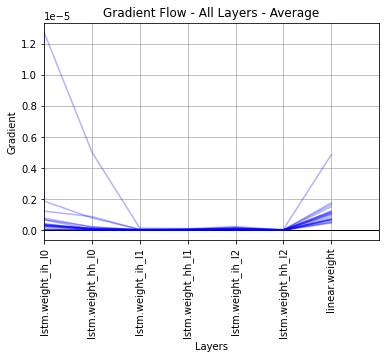

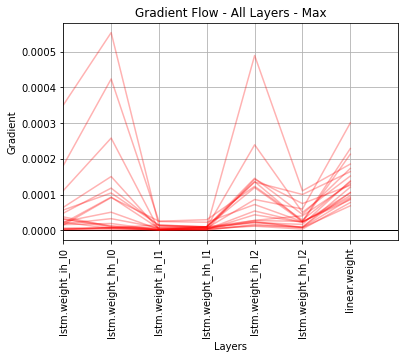

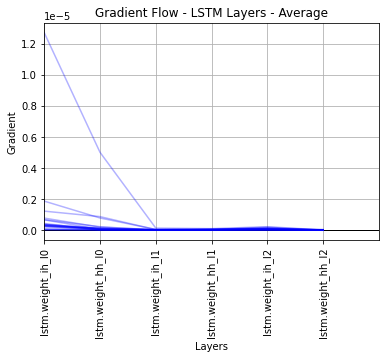

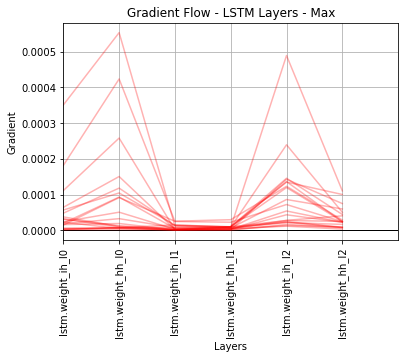

Number of gradients randomly sampled: 20
7
20
20
20
[2.53080868e-13 1.05395463e-16 0.00000000e+00 1.69129186e-17
 2.46486898e-22 6.11035578e-19 6.15088086e-14]
[1.07158635e-06 4.03972652e-07 3.00996606e-08 3.92929237e-08
 8.31448015e-08 1.19228363e-08 1.17311663e-06]
[3.50531307e-04 5.53038262e-04 2.53911767e-05 2.96323378e-05
 4.89040918e-04 1.10375127e-04 3.00230546e-04]



Computing initial allocation policy from the training set...
Number of returns from training used for policy: 256
Initial Q:
 [3.35675234e-06 1.05609743e-03 2.01810581e-03 2.94712575e-03
 3.75536668e-03 4.93293185e-03 5.95721727e-03]
Expected Gains per Bin: [ 0.          3.97246998  4.37308377  5.26022515  1.11491141  9.68118639
  5.58014171 38.53871629]
Trades per bin: [ 0.  5.  6.  4.  3.  7.  4. 17.]

Initial Allocation Policy: [0 1 1 1 1 1 1 1]

PERFORMING VALIDATION...
2021-03-21-11-45-13/_val
Buy and Hold Baseline:
Price at start: $112.99
Price at end: $90.44
Difference: $-22.56
Return:-19.96%

Profit from trading:24.62
Return from trading:21.79%
Num trades:150
Length Returns: 760
Q:
 [3.35675234e-06 1.57543180e-03 3.13728845e-03 5.02824041e-03
 6.89345251e-03 8.93450635e-03 1.13564906e-02]
E:
 [ 0.          3.45310663 10.18221965  9.9245022   2.15717453 17.36856092
 15.35287456 34.69969356]
A:
 [0 1 1 1 1 1 1 1]
C:
 [ 0. 10.  7.  4.  1.  5. 10. 38.]
Test Time: 0.323251891136169

In [31]:
model, journal, result, policy_dict = run_hypers(train_start = '07-01-2006', train_end = '01-01-2008', valid_start = '01-02-2008', valid_end = '12-31-2009', resume_dir='', resume_epoch=-1, window_size=55, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)

In [ ]:
# Hyper-parameter Hidden Size
model, journal, result, policy_dict = run_hypers(train_start = '07-01-2006', train_end = '01-01-2008', valid_start = '01-02-2008', valid_end = '12-31-2009', resume_dir='', resume_epoch=-1, window_size=33, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=32, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
model, journal, result, policy_dict = run_hypers(train_start = '07-01-2006', train_end = '01-01-2008', valid_start = '01-02-2008', valid_end = '12-31-2009', resume_dir='', resume_epoch=-1, window_size=33, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
model, journal, result, policy_dict = run_hypers(train_start = '07-01-2006', train_end = '01-01-2008', valid_start = '01-02-2008', valid_end = '12-31-2009', resume_dir='', resume_epoch=-1, window_size=33, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=96, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
model, journal, result, policy_dict = run_hypers(train_start = '07-01-2006', train_end = '01-01-2008', valid_start = '01-02-2008', valid_end = '12-31-2009', resume_dir='', resume_epoch=-1, window_size=33, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=160, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)


C:\Users\q2\Anaconda3\envs\mlp\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



last_train_date: 2007-12-31 00:00:00
loc_last_train_date: 753
backup_index: 720
Backup date: 2007-11-12 00:00:00
Train Start Date: 2006-07-03 00:00:00
Train End Date: 2007-12-31 00:00:00
Train Length: 377
Valid Start Date: 2007-11-12 00:00:00
Valid End Date: 2009-12-31 00:00:00
Valid Length: 539
Building LSTM Model with the following parameters:
Architecture: LH
Num layers: 3
Hidden size: 32
Dropout: 0.5
Learning Rate: 0.0001
LR Decay Rate: 1
Weight Decay: 0
Window size: 33
Num Epochs: 1500
Iterations per seq: 3
Start training...
Epc  AvTrLoss  AvTrMSE   AvValMSE  MdnTrMSE  MdnValMSE  ValMDA    ValMAPE  ValMAE    PXcorr  RXcorr Secs    TTlMins
0 8.514972925186157 8.514972925186157 0.0001
   0 9.00e-04  1.11e-03  2.35e-04  5.72e-04  1.18e-04   56.73     4.43     1.21e-02  0.49    0.05   8.51   0.1
2021-03-21-17-54-49//saved_models/0_0
2021-03-21-17-54-49//saved_models/0_1
2021-03-21-17-54-49//saved_models/0_2
2021-03-21-17-54-49//saved_models/0_3
2021-03-21-17-54-49//saved_models/0_4
20

125 7.900607585906982 1475.6128160953522 0.0001
126 7.899231195449829 1483.512047290802 0.0001
127 7.847161531448364 1491.3592088222504 0.0001
128 7.837263107299805 1499.1964719295502 0.0001
129 7.695210695266724 1506.891682624817 0.0001
130 7.872392177581787 1514.7640748023987 0.0001
131 7.8683860301971436 1522.6324608325958 0.0001
132 8.239435195922852 1530.8718960285187 0.0001
133 8.250016927719116 1539.1219129562378 0.0001
134 7.8656086921691895 1546.987521648407 0.0001
135 7.765078067779541 1554.7525997161865 0.0001
136 9.318315267562866 1564.0709149837494 0.0001
137 8.707570552825928 1572.7784855365753 0.0001
138 7.8038716316223145 1580.5823571681976 0.0001
139 7.731020927429199 1588.3214070796967 0.0001
140 8.041903018951416 1596.363310098648 0.0001
141 7.812090158462524 1604.176424741745 0.0001
142 11.706745624542236 1615.8831703662872 0.0001
143 8.449880361557007 1624.3330507278442 0.0001
144 7.854123830795288 1632.1871745586395 0.0001
145 7.791609525680542 1639.97878408432 0.

259 10.063451290130615 3027.755453824997 0.0001
260 10.630282640457153 3038.385736465454 0.0001
261 8.973405361175537 3047.3591418266296 0.0001
262 8.211854934692383 3055.571994304657 0.0001
263 7.854336500167847 3063.426330804825 0.0001
264 7.984712839126587 3071.4110436439514 0.0001
265 8.223230838775635 3079.634274482727 0.0001
266 7.870727300643921 3087.5050570964813 0.0001
267 7.883212089538574 3095.38826918602 0.0001
268 8.086798906326294 3103.475068092346 0.0001
269 10.687966108322144 3114.1630342006683 0.0001
270 8.735690832138062 3122.8987250328064 0.0001
271 8.09242582321167 3130.99915599823 0.0001
272 8.003118515014648 3139.003271341324 0.0001
273 9.16811203956604 3148.17138338089 0.0001
274 7.860469102859497 3156.0318524837494 0.0001
275 8.225939273834229 3164.2577917575836 0.0001
276 8.375761032104492 3172.6345477104187 0.0001
277 8.009783744812012 3180.6443314552307 0.0001
278 7.885967016220093 3188.530298471451 0.0001
279 9.720000267028809 3198.2502987384796 0.0001
280 8

2021-03-21-17-54-49//saved_models/400_5
2021-03-21-17-54-49//saved_models/400_6
2021-03-21-17-54-49//saved_models/400_7
2021-03-21-17-54-49//saved_models/400_8
2021-03-21-17-54-49//saved_models/400_9
Trading Validation -  MDA:48.99   Returns Correl:0.12   Num Trades:134.3   Return%:7.69
401 7.8366217613220215 4648.2076625823975 0.0001
402 7.703913927078247 4655.911576509476 0.0001
403 7.797794342041016 4663.709370851517 0.0001
404 7.7303550243377686 4671.4397258758545 0.0001
405 7.791256904602051 4679.2309827804565 0.0001
406 10.65449333190918 4689.885476112366 0.0001
407 8.175159692764282 4698.068637609482 0.0001
408 8.00793194770813 4706.07656955719 0.0001
409 8.18654727935791 4714.264120578766 0.0001
410 7.756242036819458 4722.020362615585 0.0001
411 7.75896954536438 4729.77933216095 0.0001
412 7.682928800582886 4737.462260961533 0.0001
413 7.751770734786987 4745.21403169632 0.0001
414 8.01082181930542 4753.224853515625 0.0001
415 7.913609981536865 4761.138463497162 0.0001
416 9.037

544 8.109071016311646 6127.807290554047 0.0001
545 9.774563312530518 6137.581853866577 0.0001
546 9.487573862075806 6147.069427728653 0.0001
547 8.309120655059814 6155.378548383713 0.0001
548 7.796107530593872 6163.174655914307 0.0001
549 7.742929458618164 6170.917585372925 0.0001
550 8.458549499511719 6179.3761348724365 0.0001
 550 1.62e-05  4.13e-05  4.45e-05  1.85e-05  1.96e-05   59.65     1.96     5.39e-03  0.74    0.20   8.46   103.0
2021-03-21-17-54-49//saved_models/550_0
2021-03-21-17-54-49//saved_models/550_1
2021-03-21-17-54-49//saved_models/550_2
2021-03-21-17-54-49//saved_models/550_3
2021-03-21-17-54-49//saved_models/550_4
2021-03-21-17-54-49//saved_models/550_5
2021-03-21-17-54-49//saved_models/550_6
2021-03-21-17-54-49//saved_models/550_7
2021-03-21-17-54-49//saved_models/550_8
2021-03-21-17-54-49//saved_models/550_9
Trading Validation -  MDA:48.39   Returns Correl:0.12   Num Trades:109.5   Return%:2.33
551 7.799623250961304 6327.197220563889 0.0001
552 9.907015323638916 

In [ ]:
model, journal, result, policy_dict = run_hypers(train_start = '01-01-2012', train_end = '01-01-2015', valid_start = '01-02-2015', valid_end = '12-31-2016', resume_dir='', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
model, journal, result, policy_dict = run_hypers(train_start = '01-01-2013', train_end = '01-01-2016', valid_start = '01-02-2016', valid_end = '12-31-2017', resume_dir='', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
model, journal, result, policy_dict = run_hypers(train_start = '01-01-2014', train_end = '01-01-2017', valid_start = '01-02-2017', valid_end = '12-31-2018', resume_dir='', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
model, journal, result, policy_dict = run_hypers(train_start = '01-01-2015', train_end = '01-01-2018', valid_start = '01-02-2018', valid_end = '12-18-2019', resume_dir='', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)

In [ ]:
# This extends the training period while keeping a constant length validation period (2018-2019)
model, journal, result, policy_dict = run_hypers(train_start = '01-01-2015', train_end = '01-01-2018', valid_start = '01-02-2018', valid_end = '12-18-2019', resume_dir='', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
model, journal, result, policy_dict = run_hypers(train_start = '01-01-2014', train_end = '01-01-2018', valid_start = '01-02-2018', valid_end = '12-18-2019', resume_dir='', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=2000, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
model, journal, result, policy_dict = run_hypers(train_start = '01-01-2013', train_end = '01-01-2018', valid_start = '01-02-2018', valid_end = '12-18-2019', resume_dir='', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=2500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
model, journal, result, policy_dict = run_hypers(train_start = '01-01-2012', train_end = '01-01-2018', valid_start = '01-02-2018', valid_end = '12-18-2019', resume_dir='', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=3000, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
model, journal, result, policy_dict = run_hypers(train_start = '01-01-2011', train_end = '01-01-2018', valid_start = '01-02-2018', valid_end = '12-18-2019', resume_dir='', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=3500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
model, journal, result, policy_dict = run_hypers(train_start = '01-01-2010', train_end = '01-01-2018', valid_start = '01-02-2018', valid_end = '12-18-2019', resume_dir='', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=4000, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)


In [ ]:
model, journal, result, policy_dict = run_hypers(resume_dir='', resume_epoch=-1, window_size=22, asset='SPY', train_epochs=3000, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=32, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)


In [ ]:
model, journal, result, policy_dict = run_hypers(resume_dir='', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=2000, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-3, dr=0.995, wd=0, trading_validation_period=50, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)

In [ ]:
# Example of resuming training on a previous run
model, journal, result, policy_dict = run_hypers(resume_dir='CH14 - Exp 2 - 2000 epochs/2021-03-01-20-54-12', resume_epoch=-1, window_size=11, asset='SPY', train_epochs=2000, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=10, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)

In [ ]:
def run_out_of_sample_test(model, D, Q, E, A, basefn='', asset='SPY', window_size=11, iter_per_seq=3, lr=1E-3, dr=0):
    
    # Go get the data for the asset
    abs_df = get_data(asset_name=asset, directory=os.path.join('..','..','data','yahoo_data'), start_date='01-01-2005', stop_date='12-20-2019')

    # Add the Prev Adj Close, drop volume etc
    abs_df = add_features_to_df(abs_df)
    
    # Normalise the entire dataset
    df, scale, offset = normalise_df(abs_df)
    
    # Out of sample test set
    test_start = '01-01-2010'
    test_end = '12-20-2019'
    
#    test_asset_dict = {}
       
#    backup_index = len(test_asset_df) - window_size
#    backup_date = df['Date'].iloc[backup_index]
    
    # Mask off the test data and assign result to a test_asset dataframe
    mask = (df['Date'] >= test_start) & (df['Date'] <= test_end)
    test_asset_df = df.loc[mask]
    
    # Reset the indices to start from 0 again for each of the dataframes
    test_asset_df.index = np.arange(test_asset_df.shape[0]) 
    
    # Generate test attribute set
    test_seq, test_labels = create_input_sequences_from_df(test_asset_df, window_size)

    # Convert our list of lists to Tensors
    test_seq = torch.FloatTensor(test_seq)
    test_labels = torch.FloatTensor(test_labels)
        
    percentiles = [0,10,20,30,40,50,60]

    model, D, Q, E, A, journal, test_result_dict = test_trading_system(model, test_seq, test_labels, D, Q, E, A, percentiles, basefn=basefn, scale=scale, offset=offset, iter_per_seq=iter_per_seq, lr = lr, dr = dr, verbosity=0)
    
    return model, D, Q, E, A, test_result_dict
   
    

In [ ]:
def run_trading_validation(model, D, Q, E, A, predictor="pytorch_lstm", drunk_genius_accuracy=0.5, valid_start='01-02-2008', valid_end='12-31-2009', basefn='', asset='SPY', window_size=11, iter_per_seq=3, lr=1E-3, dr=0):
    
    
    # Go get the data for the asset
    abs_df = get_data(asset_name=asset, directory=os.path.join('..','..','data','yahoo_data'), start_date='01-01-2005', stop_date='12-20-2019')

    # Add the Prev Adj Close, drop volume etc
    abs_df = add_features_to_df(abs_df)
    
    # Normalise the entire dataset
    df, scale, offset = normalise_df(abs_df)
    
    # Training set
#    train_start = '01-01-2005'
#    train_end = '01-01-2008'    
            
    # Mask off the training data and assign result to a train_asset dataframe
#    mask = (df['Date'] >= train_start) & (df['Date'] <= train_end)
#    train_asset_df = df.loc[mask]
    
#    backup_index = len(train_asset_df) - window_size
#    backup_date = df['Date'].iloc[backup_index]
    
    # Mask off the validation data and assign result to a valid_asset dataframe

    mask = (df['Date'] >= valid_start) & (df['Date'] <= valid_end)
    valid_asset_df = df.loc[mask]
           
    # Reset the indices to start from 0 again for each of the dataframes
#    train_asset_df.index = np.arange(train_asset_df.shape[0])   
    valid_asset_df.index = np.arange(valid_asset_df.shape[0])    
    
    print("Valid Start Date:", valid_asset_df['Date'].iloc[0])
    print("Valid End Date:", valid_asset_df['Date'].iloc[-1])
    print("Valid Length:", len(valid_asset_df))

    # Generate validation attribute set
    valid_seq, valid_labels = create_input_sequences_from_df(valid_asset_df, window_size)

    # Convert our list of lists to Tensors
    valid_seq = torch.FloatTensor(valid_seq)
    valid_labels = torch.FloatTensor(valid_labels)
                    
    percentiles = [0,10,20,30,40,50,60]

    model, D, Q, E, A, journal, test_result_dict = test_trading_system(model, valid_seq, valid_labels, D, Q, E, A, percentiles, 
                        predictor=predictor, drunk_genius_accuracy=drunk_genius_accuracy, basefn=basefn, scale=scale, offset=offset, iter_per_seq=iter_per_seq, lr = lr, 
                        dr = dr, verbosity=0)
    
#    print(test_result_dict)
    return model, D, Q, E, A, test_result_dict
   

In [ ]:
# This function runs a validation / test repeatability evaluation on a saved model from training

def run_trading_trials(predictor='pytorch_lstm', drunk_genius_accuracy=0.5, valid_start='01-02-2008', valid_end='12-31-2009',savedfn='', model_num=-1, num_trials=10, run_test=0, iter_per_seq=3, lr=1E-3, dr=0):

    model_fn = savedfn + 'epoch' + str(model_num) + '.mdl'
    print(model_fn)
    
    DQEA_fn = savedfn + 'DQEAC_dict' + str(model_num) + '.pkl'
    print(DQEA_fn)
    
    resultsfn = datetime.today().strftime('%Y-%m-%d-%H-%M-%S' + '/')
    
    # Make a results directory. If the 'directory' doesn't exist, create it
    if os.path.isdir(resultsfn) == False:
        os.mkdir(resultsfn)       

    with open(resultsfn + 'val_results.csv', 'w', newline='') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(['N', 'iter_per_seq', 'lr', 'dr', 'num_trades', 'trade_return'])     

    with open(resultsfn + 'test_results.csv', 'w', newline='') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(['N', 'num_trades', 'trade_return'])
            
    with open(resultsfn + 'val_test_summary.csv', 'w', newline='') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(['N','iter_per_seq', 'lr', 'dr', 'mean_val_trades','mean_val_returns','std_val_returns','min_val_returns',
                     'max_val_returns', 'mean_MDA', 'mean_RtCorr', 'mean_MSE', 'mean_MAE', 'mean_MAPE',
                     'mean_test_trades', 'mean_test_returns', 'std_test_returns', 'min_test_returns',
                     'max_test_returns'])
    
    val_trades = []
    test_trades = []
    val_mda = []
    val_mae = []
    val_mape = []
    val_rxcorr = []
    val_mse = []
    val_returns = []
    test_returns = []

    for i in range(num_trials):
        saved_model = torch.load(model_fn)
    
        with open(DQEA_fn, 'rb') as fp:
            saved_DQEAC = pickle.load(fp)
        
        D, Q, E, A, C = saved_DQEAC['D'], saved_DQEAC['Q'], saved_DQEAC['E'], saved_DQEAC['A'], saved_DQEAC['C']    
    
        model, D, Q, E, A, result_dict = run_trading_validation(saved_model, D, Q, E, A, predictor=predictor, 
                                                                drunk_genius_accuracy=drunk_genius_accuracy,
                                                                valid_start=valid_start, valid_end=valid_end, 
                                                                basefn=resultsfn+str(i)+'_', iter_per_seq=iter_per_seq, 
                                                                lr=lr, dr=dr)
        
        print("Val:", i, iter_per_seq, lr,dr, result_dict['num_trades'], result_dict['trade_return'], 
              result_dict['MDA'], result_dict['RXCORR'], result_dict['MSE'])
        
        val_returns.append(result_dict['trade_return'])
        val_trades.append(result_dict['num_trades'])
        val_mda.append(result_dict['MDA'])
        val_mae.append(result_dict['MAE'])        
        val_mape.append(result_dict['MAPE'])                
        val_rxcorr.append(result_dict['RXCORR'])
        val_mse.append(result_dict['MSE'])
        
        with open(resultsfn + 'val_results.csv', 'a', newline='') as myfile:
            wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
            wr.writerow([i, iter_per_seq, lr, dr, result_dict['num_trades'],result_dict['trade_return'], result_dict['MDA'],
                        result_dict['RXCORR'], result_dict['MSE'], result_dict['MAE'], result_dict['MAPE']])
    
        if run_test:
            model, D, Q, E, A, test_result_dict = run_out_of_sample_test(model, D, Q, E, A, basefn=resultsfn+str(i)+'_', iter_per_seq=iter_per_seq, lr=lr, dr=dr)
            print("Test:", i, test_result_dict['num_trades'], test_result_dict['trade_return'])
            test_returns.append(test_result_dict['trade_return'])
            test_trades.append(test_result_dict['num_trades'])    
        
            with open(resultsfn + 'test_results.csv', 'a', newline='') as myfile:
                wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
                wr.writerow([i,test_result_dict['num_trades'],test_result_dict['trade_return']])

    if run_test:
        print(model_num, np.mean(val_trades),np.mean(val_returns), np.mean(test_trades),np.mean(test_returns))
    else:
        print(model_num, np.mean(val_trades),np.mean(val_returns))
    
    with open(resultsfn + 'val_test_summary.csv', 'a', newline='') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        if run_test:
            wr.writerow([num_trials,iter_per_seq, lr, dr,np.mean(val_trades),np.mean(val_returns),np.std(val_returns),
                         np.min(val_returns),np.max(val_returns), np.mean(val_mda), np.mean(val_rxcorr), np.mean(val_mse),
                         np.mean(val_mae), np.mean(val_mape), 
                         np.mean(test_trades),np.mean(test_returns),np.std(test_returns),np.min(test_returns),np.max(test_returns)])
        else:
            wr.writerow([i,iter_per_seq, lr, dr,np.mean(val_trades),np.mean(val_returns),np.std(val_returns),np.min(val_returns),
                         np.max(val_returns), np.mean(val_mda), np.mean(val_rxcorr), np.mean(val_mse), np.mean(val_mae), 
                        np.mean(val_mape)])

    

In [ ]:
# This is the last 2 years of the rolling period
# savedfn = 'CH15 - Exp7 - Roll forward train validation period/2018 - 2021-03-16-00-08-34/saved_models/'
# run_trading_trials(valid_start='01-01-2018', valid_end='12-19-2019',savedfn=savedfn, model_num=900, num_trials=10, run_test=0, iter_per_seq=3, lr=1E-3, dr=1)

# This is the best performing period and model I saw in the rolling experiment
# saved_fn = 'CH15 - Exp7 - Roll forward train validation period/2009 - 2021-03-13-14-20-53/saved_models'
#run_trading_trials(valid_start='12-15-2006', valid_end='12-31-2008',savedfn=savedfn, model_num=850, num_trials=10, run_test=0, iter_per_seq=3, lr=1E-3, dr=1)

# 
saved_fn = 'Ch15 - CH16 - Exp8 - Expanding training period/3 year partial - 2021-03-16-13-05-13/saved_models'
run_trading_trials(predictor="pytorch_lstm", valid_start='12-13-2017', valid_end='12-18-2019',savedfn=savedfn, model_num=750, num_trials=25, run_test=0, iter_per_seq=8, lr=1E-4, dr=1)


In [ ]:
saved_fn = 'Ch15 - CH16 - Exp8 - Expanding training period/3 year partial - 2021-03-16-13-05-13/saved_models'
for drunk_genius_accuracy in np.arange(0,1.1,0.1):
    run_trading_trials(predictor="drunk_genius", drunk_genius_accuracy=drunk_genius_accuracy, valid_start='12-13-2017', valid_end='12-18-2019',savedfn=savedfn, model_num=750, num_trials=25, run_test=0, iter_per_seq=3, lr=1E-3, dr=1)


In [ ]:
# 2008
saved_fn = 'CH15 - Exp7 - Roll forward train validation period/2008 - 2021-03-03-17-09-15 LR1E-4 LRD0 - baseline from CH15 Exp2/saved_models'
run_trading_trials(predictor="pytorch_lstm", valid_start='12-14-2007', valid_end='12-31-2009',savedfn=savedfn, model_num=1050, num_trials=25, run_test=0, iter_per_seq=3, lr=1E-3, dr=1)


In [ ]:
# 2009
saved_fn = 'CH15 - Exp7 - Roll forward train validation period/2009 - 2021-03-13-14-20-53/saved_models'
run_trading_trials(predictor="pytorch_lstm", valid_start='12-13-2008', valid_end='12-31-2010',savedfn=savedfn, model_num=850, num_trials=25, run_test=0, iter_per_seq=3, lr=1E-3, dr=1)

# 2010
saved_fn = 'CH15 - Exp7 - Roll forward train validation period/2010 - 2021-03-13-21-37-25/saved_models'
run_trading_trials(predictor="pytorch_lstm", valid_start='12-13-2009', valid_end='12-31-2011',savedfn=savedfn, model_num=650, num_trials=25, run_test=0, iter_per_seq=3, lr=1E-3, dr=1)

# 2011
saved_fn = 'CH15 - Exp7 - Roll forward train validation period/2011 - 2021-03-14-04-34-53/saved_models'
run_trading_trials(predictor="pytorch_lstm", valid_start='12-13-2010', valid_end='12-31-2012',savedfn=savedfn, model_num=700, num_trials=25, run_test=0, iter_per_seq=3, lr=1E-3, dr=1)

# 2012
saved_fn = 'CH15 - Exp7 - Roll forward train validation period/2012 - 2021-03-14-11-33-41/saved_models'
run_trading_trials(predictor="pytorch_lstm", valid_start='12-13-2011', valid_end='12-31-2013',savedfn=savedfn, model_num=450, num_trials=25, run_test=0, iter_per_seq=3, lr=1E-3, dr=1)

# 2013
saved_fn = 'CH15 - Exp7 - Roll forward train validation period/2013 - 2021-03-14-18-33-45/saved_models'
run_trading_trials(predictor="pytorch_lstm", valid_start='12-13-2012', valid_end='12-31-2014',savedfn=savedfn, model_num=650, num_trials=25, run_test=0, iter_per_seq=3, lr=1E-3, dr=1)

# 2014
saved_fn = 'CH15 - Exp7 - Roll forward train validation period/2014 - 2021-03-15-01-30-56/saved_models'
run_trading_trials(predictor="pytorch_lstm", valid_start='12-13-2013', valid_end='12-31-2015',savedfn=savedfn, model_num=1050, num_trials=25, run_test=0, iter_per_seq=3, lr=1E-3, dr=1)

# 2015
saved_fn = 'CH15 - Exp7 - Roll forward train validation period/2015 - 2021-03-15-08-29-15/saved_models'
run_trading_trials(predictor="pytorch_lstm", valid_start='12-13-2014', valid_end='12-31-2016',savedfn=savedfn, model_num=650, num_trials=25, run_test=0, iter_per_seq=3, lr=1E-3, dr=1)

# 2016
saved_fn = 'CH15 - Exp7 - Roll forward train validation period/2016 - 2021-03-15-13-41-40/saved_models'
run_trading_trials(predictor="pytorch_lstm", valid_start='12-13-2015', valid_end='12-31-2017',savedfn=savedfn, model_num=900, num_trials=25, run_test=0, iter_per_seq=3, lr=1E-3, dr=1)

# 2017
saved_fn = 'CH15 - Exp7 - Roll forward train validation period/2017 - 2021-03-15-18-54-04/saved_models'
run_trading_trials(predictor="pytorch_lstm", valid_start='12-13-2016', valid_end='12-31-2018',savedfn=savedfn, model_num=300, num_trials=25, run_test=0, iter_per_seq=3, lr=1E-3, dr=1)

# 2018
saved_fn = 'CH15 - Exp7 - Roll forward train validation period/2018 - 2021-03-16-00-08-34/saved_models'
run_trading_trials(predictor="pytorch_lstm", valid_start='12-13-2017', valid_end='12-31-2019',savedfn=savedfn, model_num=900, num_trials=25, run_test=0, iter_per_seq=3, lr=1E-3, dr=1)



In [ ]:
model, journal, result, policy_dict = run_hypers(window_size=11, asset='SPY', train_epochs=4000, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=10, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)

In [ ]:
import pickle
with open('policy_dict.pkl','wb') as fp:
    pickle.dump(policy_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
    


In [ ]:
model, journal, result = run_hypers(window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=10, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=10, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)


In [ ]:
model, journal, result = run_hypers(window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, trading_validation_period=10, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)

In [ ]:
model, journal, result = run_hypers(window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=2, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=4, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=5, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=6, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)

In [ ]:
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.00001, dr=0.5, wd=0, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)

In [ ]:
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.00001, dr=0.99, wd=0, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=1)

In [ ]:
for trial in range(100):
    iter_per_seq = random.choice([10, 20, 30, 40, 50, 60 ,70, 80, 90, 100])
    window_size = random.choice([11, 22, 44])
    hidden_size = random.choice([32, 64, 128])
    num_layers = random.choice([2, 3])
    arch = random.choice(['LH','AH'])
    dropout = random.choice([0, 0.5, 0.7])
    lr = random.choice([1E-3, 5E-4, 1E-4, 5E-5, 1E-5])
    dr = random.choice([0.9, 0.93, 0.95, 0.97, 0.99, 1])
    model, journal, result = run_hypers(window_size=window_size, asset='SPY', train_epochs=1, iter_per_seq=iter_per_seq, arch=arch, num_layers=num_layers, hidden_size=hidden_size, dropout=dropout, lr=lr, dr=dr, wd=0, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=0)    
    

In [ ]:
for r in range(10):
    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=40, arch='AH', num_layers=2, hidden_size=64, dropout=0.7, lr=1E-4, dr=0.95, wd=0, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=0)    

In [ ]:
for r in range(10):
    model, journal, result = run_hypers(window_size=22, asset='SPY', train_epochs=1, iter_per_seq=50, arch='LH', num_layers=2, hidden_size=32, dropout=0.7, lr=1E-3, dr=1, wd=0, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=0)    

In [ ]:
model, journal, result = run_hypers(window_size=22, asset='SPY', train_epochs=1, iter_per_seq=50, arch='LH', num_layers=2, hidden_size=32, dropout=0, lr=1E-3, dr=1, wd=0, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=0)
model, journal, result = run_hypers(window_size=22, asset='SPY', train_epochs=1, iter_per_seq=50, arch='LH', num_layers=2, hidden_size=32, dropout=0.1, lr=1E-3, dr=1, wd=0, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=0)    
model, journal, result = run_hypers(window_size=22, asset='SPY', train_epochs=1, iter_per_seq=50, arch='LH', num_layers=2, hidden_size=32, dropout=0.2, lr=1E-3, dr=1, wd=0, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=0)    
model, journal, result = run_hypers(window_size=22, asset='SPY', train_epochs=1, iter_per_seq=50, arch='LH', num_layers=2, hidden_size=32, dropout=0.3, lr=1E-3, dr=1, wd=0, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=0)    
model, journal, result = run_hypers(window_size=22, asset='SPY', train_epochs=1, iter_per_seq=50, arch='LH', num_layers=2, hidden_size=32, dropout=0.4, lr=1E-3, dr=1, wd=0, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=0)    
model, journal, result = run_hypers(window_size=22, asset='SPY', train_epochs=1, iter_per_seq=50, arch='LH', num_layers=2, hidden_size=32, dropout=0.5, lr=1E-3, dr=1, wd=0, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=0)    
model, journal, result = run_hypers(window_size=22, asset='SPY', train_epochs=1, iter_per_seq=50, arch='LH', num_layers=2, hidden_size=32, dropout=0.6, lr=1E-3, dr=1, wd=0, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=0)    
model, journal, result = run_hypers(window_size=22, asset='SPY', train_epochs=1, iter_per_seq=50, arch='LH', num_layers=2, hidden_size=32, dropout=0.7, lr=1E-3, dr=1, wd=0, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=0)    
model, journal, result = run_hypers(window_size=22, asset='SPY', train_epochs=1, iter_per_seq=50, arch='LH', num_layers=2, hidden_size=32, dropout=0.8, lr=1E-3, dr=1, wd=0, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=0)    
model, journal, result = run_hypers(window_size=22, asset='SPY', train_epochs=1, iter_per_seq=50, arch='LH', num_layers=2, hidden_size=32, dropout=0.9, lr=1E-3, dr=1, wd=0, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=0)    
model, journal, result = run_hypers(window_size=22, asset='SPY', train_epochs=1, iter_per_seq=50, arch='LH', num_layers=2, hidden_size=32, dropout=1, lr=1E-3, dr=1, wd=0, run_out_of_sample_test=0, train_only=0, verbosity=1, plot=0)    

In [ ]:
model, journal, result = run_hypers(window_size=11, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, run_out_of_sample_test=0, train_only=0, verbosity=2, plot=1)    

In [ ]:
model, journal, result = run_hypers(window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, run_out_of_sample_test=0, train_only=0, verbosity=2, plot=1)    

In [ ]:
model, journal, result = run_hypers(window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, run_out_of_sample_test=0, train_only=0, verbosity=2, plot=1)    

In [ ]:
model, journal, result = run_hypers(window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=2, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, run_out_of_sample_test=0, train_only=0, verbosity=2, plot=1)    

In [ ]:
model, journal, result = run_hypers(window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=3, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, run_out_of_sample_test=0, train_only=0, verbosity=2, plot=1)    

In [ ]:
model, journal, result = run_hypers(window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=4, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, run_out_of_sample_test=0, train_only=0, verbosity=2, plot=1)    

In [ ]:
model, journal, result = run_hypers(window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=5, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, run_out_of_sample_test=0, train_only=0, verbosity=2, plot=1)

In [ ]:
model, journal, result = run_hypers(window_size=11, asset='SPY', train_epochs=1500, iter_per_seq=6, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=1E-4, dr=1, wd=0, run_out_of_sample_test=0, train_only=0, verbosity=2, plot=1)

In [ ]:
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)

In [ ]:
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)

In [ ]:
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)

In [ ]:
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.00001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.00001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.00001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.00001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.00001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)

In [ ]:
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.000001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.000001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.000001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.000001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.000001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)

In [ ]:
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.99, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.99, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.99, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.99, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.99, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)

In [ ]:
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.95, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.95, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.95, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.95, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.95, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)

In [ ]:
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.9, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.9, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.9, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.9, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.9, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)

In [ ]:
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.90, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.91, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.92, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.93, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.94, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.95, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.96, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.97, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.98, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.99, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)

In [ ]:
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.00001, dr=0.90, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.00001, dr=0.91, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.00001, dr=0.92, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.00001, dr=0.93, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.00001, dr=0.94, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.00001, dr=0.95, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.00001, dr=0.96, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.00001, dr=0.97, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.00001, dr=0.98, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.00001, dr=0.99, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)

In [ ]:
model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.95, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.95, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.95, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.95, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.95, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)

In [ ]:
model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.00001, dr=0.95, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.00001, dr=0.95, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.00001, dr=0.95, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.00001, dr=0.95, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.00001, dr=0.95, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)

In [ ]:
model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.000001, dr=0.95, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.000001, dr=0.95, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.000001, dr=0.95, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.000001, dr=0.95, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.000001, dr=0.95, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)

In [ ]:
model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.001, dr=0.999, wd=0, run_out_of_sample_test=0, verbosity=2, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.001, dr=0.999, wd=1E-8, run_out_of_sample_test=0, verbosity=2, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.001, dr=0.999, wd=1E-7, run_out_of_sample_test=0, verbosity=2, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.001, dr=0.999, wd=1E-6, run_out_of_sample_test=0, verbosity=2, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.001, dr=0.999, wd=1E-5, run_out_of_sample_test=0, verbosity=2, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.001, dr=0.999, wd=1E-4, run_out_of_sample_test=0, verbosity=2, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.001, dr=0.999, wd=1E-3, run_out_of_sample_test=0, verbosity=2, plot=1)


In [ ]:
# r1 - r8 run on 16/2/21-18/2/21
    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.001, dr=1, wd=5E-6, run_out_of_sample_test=0, verbosity=2, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, wd=5E-6, run_out_of_sample_test=0, verbosity=2, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, wd=5E-6, run_out_of_sample_test=0, verbosity=2, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, wd=5E-6, run_out_of_sample_test=0, verbosity=2, plot=1)
    model, journal, result = run_hypers(window_size=11, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, wd=5E-6, run_out_of_sample_test=0, verbosity=2, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.0001, dr=1, wd=5E-6, run_out_of_sample_test=0, verbosity=2, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.0001, dr=1, wd=5E-6, run_out_of_sample_test=0, verbosity=2, plot=1)
    model, journal, result = run_hypers(window_size=11, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.0001, dr=1, wd=5E-6, run_out_of_sample_test=0, verbosity=2, plot=1)

In [ ]:
# make_synthetic_stock(source_asset_name='SPY', new_name='SYN', directory=os.path.join('..','..','data','yahoo_data'), start_date='01-01-2005', stop_date='12-20-2019', trend_list=[(10,37),(7,17),(3,7)], adj_close_start=85, price_slope=0, close_scale=1)

In [ ]:
make_synthetic_stock(source_asset_name='SPY', new_name='SYN2', directory=os.path.join('..','..','data','yahoo_data'), start_date='01-01-2005', stop_date='12-20-2019', trend_list=[(10,33),(5,17)], adj_close_start=85, price_slope=0, close_scale=1)

In [ ]:
make_synthetic_stock(source_asset_name='SPY', new_name='SYN3', directory=os.path.join('..','..','data','yahoo_data'), start_date='01-01-2005', stop_date='12-20-2019', trend_list=[(10,33),(5,17)], adj_close_start=85, price_slope=0.01, close_scale=1)

In [ ]:
make_synthetic_stock(source_asset_name='SPY', new_name='SYN4', directory=os.path.join('..','..','data','yahoo_data'), start_date='01-01-2005', stop_date='12-20-2019', trend_list=[(10,33),(5,17),(3,11),(2,3)], adj_close_start=85, price_slope=0.01, close_scale=1)

In [ ]:
make_synthetic_stock(source_asset_name='SPY', new_name='SYN4S', directory=os.path.join('..','..','data','yahoo_data'), start_date='01-01-2005', stop_date='03-31-2005', trend_list=[(10,33),(5,17),(3,11),(2,3)], adj_close_start=85, price_slope=0.01, close_scale=1)

In [ ]:
iterations_win_leg()
epochs_win_leg()
iterations_lr_leg()



In [ ]:
# SPY Num Iterations Leg - using optimum settings from SYN4 experiments
def spy_iterations_leg():
    %mkdir "num_iter"
    %cd num_iter
    
    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=50, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=200, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=300, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=400, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    %cd ..
    

In [ ]:
# SPY Num Iterations Leg - using optimum settings from SYN4 experiments
def spy_iterations_leg2():
    %mkdir "num_iter2"
    %cd num_iter
    
    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=1100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=1200, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=1300, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=1400, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
#    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=400, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    %cd ..

In [ ]:
spy_iterations_leg2()

In [ ]:
# Num Iterations Leg - using optimum settings from SYN4 experiments
def iterations_leg():
    %mkdir "num_iter"
    %cd num_iter
    
    model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=5, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=20, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=40, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=80, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    %cd ..
    

In [ ]:
iterations_leg()

In [ ]:
# Iterations, Window size leg
def iterations_win_leg():
    %mkdir "iter_win_len"
    %cd iter_win_len
    model, journal, result = run_hypers(window_size=1, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=2, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=3, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=7, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=11, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=88, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    %cd ..


In [ ]:
# Epochs, Window size leg
def epochs_win_leg():
    %mkdir "epoch_win_len"
    %cd epoch_win_len

    model, journal, result = run_hypers(window_size=1, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=2, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=3, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=7, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=11, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=88, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)

    %cd ..

In [ ]:
# Iterations, Learning rate leg
def iterations_lr_leg():
    %mkdir "iter_lr"
    %cd iter_lr
    
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.000001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.00001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.01, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.1, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)

    %cd ..

In [ ]:
# Epoch, Learning rate leg
def epoch_lr_leg():
    %mkdir "epoch_lr"
    %cd epoch_lr
    
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.000001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.00001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.01, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.1, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    
    %cd ..


In [ ]:
# Iterations, Hidden size leg
def iterations_hidden_size_leg():
    %mkdir "iter_hidden_len"
    %cd iter_hidden_len
    
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=2, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=4, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=8, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=16, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=32, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=256, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    
    %cd ..

In [ ]:
# Epochs, Hidden size leg
def epochs_hidden_size_leg():
    %mkdir "epoch_hidden_len"
    %cd epoch_hidden_len
    
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=2, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=4, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=8, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=16, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=32, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=256, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    
    %cd ..

In [ ]:
# Everything past here is graveyard / experimental

In [ ]:
# THIS IS THE OLD (SLOW) VERSION OF TRAIN_MODEL - IT WAS REPLACED BY TRAIN_MODELQ

# Trains the given LSTM model. Also collects validation data (predicting the next day) and collects stats
# for both.  These are used to observe training vs validation but also to construct the first allocation policy.

def train_model(model, train_seq, train_labels, scale=1, offset=1, train_start=0, train_length=1, epochs = 20, iter_per_seq=1, max_iter=1600, lr = 0.001, dr=0.999, wd=0.0, verbosity=0, basefn='',percentiles=[0,10,20,30,40,50,60], trading_validation_period=100, valid_seq=[], valid_labels=[], plot=0):
    input_size = 6
    
    
    # if plot level is 4, plot graphs on screen for every inner loop training run
    if plot == 4:
        dump_log_interval = 1
    else:
        dump_log_interval = 10 # otherwise do it every 10
        
    loss_function = nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = wd)
    my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer = optimizer, gamma = dr)
    
    batch_size = 1  # batch mode isn't used actually but including for future possible use
    
    with open(basefn + 'train.csv', 'a', newline='') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(['Epc','AvTrLoss','AvTrMSE','AvValMSE','MdnTrMSE','MdnValMSE','ValMDA','ValMAPE','ValMAE','PXcorr','RXcorr',
                     'EpcSecs','TtlMins'])
        
    with open(basefn + 'trade_validation.csv', 'w', newline='') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(['Epoch','MDA','MSE','MAE','MAPE','X-Correl','Num-trades','AveRt%','MdnRT%','MinRt%','MaxRt%',
                    'RangeRt%','StdDevRt%'])
            
    # Outputs a summary line for each Epoch
    if verbosity == 1:
        print('Epc  AvTrLoss  AvTrMSE   AvValMSE  MdnTrMSE  MdnValMSE  ValMDA    ValMAPE  ValMAE    PXcorr  RXcorr Secs    TTlMins')

    # Outputs a summary line for each sequence in each epoch
    if verbosity == 2:
        print('EPc  Seq#   TrLoss    TrMSE     PredR   ActRt   ValLoss   VAdjC    VPred   VAct      VPredRt   VActRt   RunMDA')            
                            
    
#    train_losses = []
#    val_adj_close_price = []
    ave_grads = []
    max_grads = []
    min_grads = []
    
    # If the number of epochs is high, just sample the gradients stochastically to avoid retaining too much
    # data.
    if (epochs * train_length) > 1000:
        sample_grads = 1000.0 / (epochs * train_length)
    else:
        sample_grads = 1.0

    start_time = time.time()        

    # How many times through the entire training set
    for i in range(epochs):
        train_losses = []
        val_adj_close_price = []        
        train_mses = []
        val_mses = []
        val_pred_rt = []
        val_act_rt = []
        val_pred_price = []
        val_act_price = []        
        running_mda = 0
        epoch_start_time = time.time()
        # Each sample in the training set
        for j in range(train_start, train_start + train_length):      

            # Reset the learning rate each time for the inner loop
            optimizer.param_groups[0]['lr'] = lr
            
            t_mse_list = []
            v_mse_list = []
            il_ave_grads = []
            il_max_grads = []
            
#            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = wd)
#            my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer = optimizer, gamma = dr)
            
#            if j%dump_log_interval == 0:
#                dump_log = 1
#            else:
            # Disable inner loop instrumentations for now
            dump_log = 0
            
            # How many times we train on each sample as we go
            for iter in range(iter_per_seq):
                # Send input / label data to Cuda if available
                inputs = train_seq[j].to(device)
                labels = train_labels[j].to(device)
        
                model.train()
            
                # Initialise hidden states before every training event
                h = model.init_hidden(batch_size)  
                                    
                optimizer.zero_grad()
        
                y_pred, h, lstm_out = model(inputs, h)
            
                if dump_log:
                    tp = y_pred[-1].item()
                    ta = labels[-1].item()
                    t_mse = (tp-ta)**2

                # y_pred and labels are both size T - sequence to sequence loss function
                train_loss = loss_function(y_pred, labels)
            
                # Compute gradients and update the model
                train_loss.backward()
                                
                optimizer.step()

                my_lr_scheduler.step()
                
                # Do an inner loop validation
                if dump_log:
                    inputs = train_seq[j+1].to(device)
                    labels = train_labels[j+1].to(device)
            
                    with torch.no_grad():
                        h = model.init_hidden(batch_size)
                        y_pred, h, lstm_out = model(inputs, h)
                
                        vp = y_pred[-1].item()
                        va = labels[-1].item()
                        v_mse = (vp-va)**2
                
                    # write detailed training log
                    with open(basefn + 'train_inner.csv', 'a', newline='') as myfile:        
                        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
                        wr.writerow([j,iter,train_loss.item(),tp,ta,t_mse,vp,va,v_mse])
                    
                    t_mse_list.append(t_mse)
                    v_mse_list.append(v_mse)

                    # Grab the inner loop grads - only if we're plotting as we go
                    if plot >= 3:                    
                        il_ave_grad = []
                        il_max_grad = []
                        for n,p in model.named_parameters():
                            if (p.requires_grad) and ("bias" not in n):
                                il_ave_grad.append(p.grad.abs().mean())
                                il_max_grad.append(p.grad.abs().max())
                        il_ave_grads.append(il_ave_grad)
                        il_max_grads.append(il_max_grad)
            
            # After the inner loop completes, plot the inner-loop charts if enabled
            if dump_log and plot >= 3:
                plot_losses(t_mse_list, v_mse_list, title='Train / Validation Loss. Seq:'+str(j), basefn=basefn, display_plot=1, save_plot=0)
                print("last tp:",tp,"\tlast ta:",ta,"\tlast t_mse:",t_mse)
                print("last vp:",vp,"\tlast va:",va,"\tlast v_mse:",v_mse)
            
                plot_gradients(model, il_ave_grads, il_max_grads, basefn=basefn, display_plot=1, save_plot=0)

            # Sample stochastically the last set of gradients after the inner loop for plotting later
            if plot and (random.random() < sample_grads):
                ave_grad=[]
                max_grad=[]
                min_grad=[]
                for n,p in model.named_parameters():
                    if (p.requires_grad) and ("bias" not in n):
                        ave_grad.append(p.grad.abs().mean())
                        max_grad.append(p.grad.abs().max())
                        min_grad.append(p.grad.abs().min())
                ave_grads.append(ave_grad)
                max_grads.append(max_grad)
                min_grads.append(min_grad)            
            
            # Capture the (snapshot) metrics from the last inner loop cycle
            training_loss = train_loss.item()  # This is the sequence to sequence training loss                        
            train_adj_close = inputs[-1][-1].item()   # Adj close at t=0
            train_pred = y_pred[-1].item()  # Next day predicted Adj close
            train_truth = labels[-1].item()  # Next day actual Adj close
            train_mse = (train_pred - train_truth)**2   # MSE of just the predicted value vs truth
            train_predicted_return = (denormalise_value(train_pred, scale, offset) / denormalise_value(train_adj_close, scale, offset)) - 1            
            train_actual_return = (denormalise_value(train_truth, scale, offset) / denormalise_value(train_adj_close, scale, offset)) - 1

            # Outer loop validation at the end of inner loop training - we always do this regardless of what
            # validation we did in the inner loop (which is usually sampled)
            model.eval()
            
            inputs = train_seq[j+1].to(device)
            labels = train_labels[j+1].to(device)
            
            with torch.no_grad():
                h = model.init_hidden(batch_size)
        
                y_pred, h, lstm_out = model(inputs, h)
                    
                valid_adj_close = inputs[-1][-1].item()                
                valid_pred = y_pred[-1].item()
                valid_truth = labels[-1].item()
                valid_loss = (valid_pred - valid_truth)**2  # Just the mse of the valid predicted value vs truth
            
                valid_predicted_return = (denormalise_value(valid_pred, scale, offset) / denormalise_value(valid_adj_close, scale, offset)) - 1
                valid_actual_return = (denormalise_value(valid_truth, scale, offset) / denormalise_value(valid_adj_close, scale, offset)) - 1

                if (valid_predicted_return * valid_actual_return >= 0):
                    running_mda += 1                
                
                # If enabled, print results line at the end of inner loop training on each sequence
                if (verbosity==2):
                    print('{:4}'.format(i),
                            '{:4}'.format(j), 
                          '  {:1.1e}'.format(training_loss),
                          '  {:1.1e}'.format(train_mse),
                          ' {: 2.3f}'.format(100.0*train_predicted_return), 
                          ' {: 2.3f}'.format(100.0*train_actual_return),
                          '  {:1.1e}'.format(valid_loss), 
                          ' {: 1.4f}'.format(valid_adj_close), 
                          ' {: 1.4f}'.format(valid_pred), 
                          ' {: 1.4f}'.format(valid_truth),
                          ' {: 2.4f}'.format(100.0*valid_predicted_return), 
                          ' {: 2.4f}'.format(100.0*valid_actual_return),
                          '  {:2.2f}'.format(100.0*running_mda/(j+1)))
                    
                # Keep lists of the results of train / validation for each sequence for passing back up the stack
                train_losses.append(training_loss)
                train_mses.append(train_mse)
                val_mses.append(valid_loss)
                val_pred_rt.append(valid_predicted_return)
                val_act_rt.append(valid_actual_return)
                val_pred_price.append(valid_pred)
                val_act_price.append(valid_truth)
                val_adj_close_price.append(valid_adj_close)
                
            # End of outer loop                                        
           
        elapsed_secs = time.time()-start_time
        
        # We report stats on the last portion of the training
        stats_len = int(0.5 * len(train_losses))
            
        metrics_dict = compute_metrics(np.array(val_pred_rt[-stats_len:]),
                                   np.array(val_act_rt[-stats_len:]),
                                   np.array(val_pred_price[-stats_len:]),
                                   np.array(val_act_price[-stats_len:]))

        # This is the results we'll pass back up the stack for the entire training
        result_dict = {'trStats_N':stats_len, 'AvTrLoss':np.mean(train_losses[-stats_len:]),
                   'trAvTrMSE':np.mean(train_mses[-stats_len:]),
                   'trAvValMSE':np.mean(val_mses[-stats_len:]),
                   'trMdnTrMSE':np.median(train_mses[-stats_len:]),
                   'trMdnValMSE':np.median(val_mses[-stats_len:]),
                   'train_mses':train_mses, 'valid_mses':val_mses, 'val_pred_rt':val_pred_rt, 'val_act_rt':val_act_rt, 
                   'val_pred_price':val_pred_price, 'val_act_price':val_act_price, 
                   'val_adj_close_price': val_adj_close_price,
                    'trMDA': metrics_dict['MDA'],
                    'trMAPE': metrics_dict['MAPE'],
                    'trMAE': metrics_dict['MAE'],
                    'trPXCORR': metrics_dict['PXCORR'],
                    'trRXCORR': metrics_dict['RXCORR'],
                    'epoch_train_time':time.time()-epoch_start_time,
                   'train_time':elapsed_secs}
        
#        result_dict.update(metrics_dict)
        
        # Output summary stats at end of outer loop training  
        if (verbosity == 1):
            print('{:4}'.format(i),'{:4.2e}'.format(result_dict['AvTrLoss']),
                          ' {:1.2e}'.format(result_dict['trAvTrMSE']),
                          ' {:4.2e}'.format(result_dict['trAvValMSE']), 
                          ' {:1.2e}'.format(result_dict['trMdnTrMSE']),
                          ' {:4.2e}'.format(result_dict['trMdnValMSE']),                  
                          '  {:2.2f}'.format(result_dict['trMDA']), 
                          '    {:2.2f}'.format(result_dict['trMAPE']), 
                          '    {:2.2e}'.format(result_dict['trMAE']),
                          '{: 1.2f}'.format(result_dict['trPXCORR']), 
                          '  {: 1.2f}'.format(result_dict['trRXCORR']),      
                          '  {:2.2f}'.format(result_dict['epoch_train_time']),                  
                          '  {:3.1f}'.format(result_dict['train_time']/60.0))
            
        with open(basefn + 'train.csv', 'a', newline='') as myfile:
            wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
            wr.writerow([i, result_dict['AvTrLoss'],
                        result_dict['trAvTrMSE'],
                        result_dict['trAvValMSE'],
                        result_dict['trMdnTrMSE'],
                        result_dict['trMdnValMSE'],
                        result_dict['trMDA'],
                        result_dict['trMAPE'],
                        result_dict['trMAE'],
                        result_dict['trPXCORR'],
                        result_dict['trRXCORR'],
                        result_dict['epoch_train_time'],
                        result_dict['train_time']/60.0,
                        ])
        
        # Periodically perform a trading validation 
        if i%trading_validation_period == 0:
            D,Q,E,A,C = generate_initial_allocation_policy(result_dict, percentiles=percentiles, scale=scale, offset=offset, basefn=basefn, verbosity=0)
            
            # Save both the model and the initial allocation policy so we can recreate for validation / test after training
            # (pick the best model out of a complete training run after analysing the data)
            
            # Make a results directory. If the 'directory' doesn't exist, create it
            if os.path.isdir(basefn + '/saved_models') == False:
                os.mkdir(basefn + '/saved_models')
            
            torch.save(model,basefn + '/saved_models/epoch' + str(i) + '.mdl')
            
            with open(basefn + '/saved_models/DQEAC_dict' + str(i) + '.pkl','wb') as fp:
                pickle.dump({'D':D, 'Q':Q, 'E':E, 'A':A, 'C':C}, fp, protocol=pickle.HIGHEST_PROTOCOL)            

            # Note - prior to version 15, I wasn't deep copying the D,Q,E,A which means they would have been being updated
            # by trading validation.
            trial_results = []
            for trial in range(10):
                # For each trial make a deep copy of things that get modified by the validation process. Make sure that 
                # the model being trained and the allocation policy components are not being modified and we always start
                # validation from the same starting point.
                validation_model = copy.deepcopy(model)
                copy_D = copy.deepcopy(D)
                copy_Q = copy.deepcopy(Q)
                copy_E = copy.deepcopy(E)
                copy_A = copy.deepcopy(A)
                
                validation_model, copy_D, copy_Q, copy_E, copy_A, journal, test_result_dict = test_trading_system(validation_model, valid_seq, valid_labels, copy_D, copy_Q, copy_E, copy_A, percentiles, basefn=basefn+'/saved_models/'+str(i)+'_'+str(trial), scale=scale, offset=offset, iter_per_seq=iter_per_seq, lr = 0.001, dr = 1, verbosity=0)
                
                trial_results.append(test_result_dict)                

            
            mean_trial_MDA = np.mean([v['MDA'] for v in trial_results])
            mean_trial_MSE = np.mean([v['MSE'] for v in trial_results])
            mean_trial_MAE = np.mean([v['MAE'] for v in trial_results])
            mean_trial_MAPE = np.mean([v['MAPE'] for v in trial_results])
            mean_trial_RXCORR = np.mean([v['RXCORR'] for v in trial_results])
            mean_trial_num_trades = np.mean([v['num_trades'] for v in trial_results])
            trial_returns = [v['trade_return'] for v in trial_results]
            mean_trial_trade_return = np.mean(trial_returns)
            median_trial_trade_return = np.median(trial_returns)
            min_trial_trade_return = np.min(trial_returns)
            max_trial_trade_return = np.max(trial_returns)
            range_trial_trade_return = max_trial_trade_return - min_trial_trade_return
            std_trial_trade_return = np.std(trial_returns)
            
            print('Trading Validation - ',
                'MDA:{:2.2f}'.format(mean_trial_MDA),
                '  Returns Correl:{:2.2f}'.format(mean_trial_RXCORR),
                '  Num Trades:{:4}'.format(mean_trial_num_trades),
                '  Return%:{:2.2f}'.format(mean_trial_trade_return))
            
            with open(basefn + 'trade_validation.csv', 'a', newline='') as myfile:
                wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
                wr.writerow([i,mean_trial_MDA, mean_trial_MSE,
                            mean_trial_MAE, mean_trial_MAPE,
                            mean_trial_RXCORR, mean_trial_num_trades, 
                            mean_trial_trade_return, median_trial_trade_return,
                            min_trial_trade_return, max_trial_trade_return,
                            range_trial_trade_return, std_trial_trade_return])

    if plot>=1:
        plot_gradients(model, ave_grads, max_grads, basefn=basefn, display_plot=plot, save_plot=1)
        plotly_gradients(model, min_grads, max_grads, ave_grads, basefn=basefn, display_plot=plot, save_plot=1)
        plot_hidden(h, basefn=basefn, display_plot=plot, save_plot=1)
        plot_lstm_output(lstm_out, basefn=basefn, display_plot=plot, save_plot=1)
        plot_weights(model, basefn=basefn, display_plot=plot, save_plot=1)
        plot_losses(train_mses, val_mses, title='Model Training: Training Loss vs Validation Loss', basefn=basefn, display_plot=plot, save_plot=1)
        plot_returns_hist(val_pred_rt, val_act_rt, title='Model Training: Predicted vs Actual Returns', basefn=basefn+'both_', display_plot=plot, save_plot=1)
        plot_returns_hist(val_pred_rt, val_pred_rt, title='Model Training: Predicted Returns', basefn=basefn+'pred_', display_plot=plot, save_plot=1)
        plot_returns_hist(val_act_rt, val_act_rt, title='Model Training: Actual Returns', basefn=basefn+'act_', display_plot=plot, save_plot=1)    
            
    return model, result_dict



In [ ]:
test_results = []
val_results = []
for i in range(10):
    print("\nTrial:", i)
    print("********\n")
    model, journal, result = run_hypers(verbosity = 1, plot = 1)
    test_results.append(result['test_return_pct'])
    val_results.append(result['val_return_pct'])
    
print(np.mean(np.array(val_results)))
print(np.std(np.array(val_results)))

print(np.mean(np.array(test_results)))
print(np.std(np.array(test_results)))

In [ ]:
torch.set_printoptions(profile="short")

for name in model.named_parameters():
    print(name[0])
    print(name[1][:])

print(model.lstm.weight_ih_l0.size())
print(model.lstm.bias_ih_l0.size())
print(model.lstm.weight_hh_l0.size())
print(model.lstm.bias_hh_l0.size())


print(model.lstm.weight_hh_l1.size())
print(model.lstm.weight_ih_l1.size())

print(model.lstm.weight_hh_l2.size())
print(model.lstm.weight_ih_l2.size())

print(model.linear.weight.size())
print(model.linear.bias.size())





In [ ]:
# Use first asset in list of assets as the source
assets = ['SPY', 'DIA', 'ONEQ', 'IWM']

print(asset_list)
syn_df = asset_dict[asset_list[0]].copy()

display(syn_df.head(5))
print(syn_df.describe())    

asset_dict['SYN'] = syn_df 

trend_list = [(1, 20)]
make_synthetic_df(asset_dict['SYN'], trend_list, 0, 0, 1.4)

display(syn_df.head(5))
print(syn_df.describe())    


In [ ]:
import matplotlib.pyplot as plt
import cv2

# norm_img=cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# plt.imshow(img, cmap='gray')
fig, ax = plt.subplots(1,6,figsize=(20,12))
ax[0].imshow(model.lstm.weight_ih_l0.cpu().detach().numpy(), cmap='inferno')
ax[1].imshow(model.lstm.weight_hh_l0.cpu().detach().numpy(), cmap='inferno')
ax[2].imshow(model.lstm.weight_ih_l1.cpu().detach().numpy(), cmap='inferno')
ax[3].imshow(model.lstm.weight_hh_l1.cpu().detach().numpy(), cmap='inferno')
ax[4].imshow(model.lstm.weight_ih_l2.cpu().detach().numpy(), cmap='inferno')
ax[5].imshow(model.lstm.weight_hh_l2.cpu().detach().numpy(), cmap='inferno')

# ih_l0 - has dimension 6 x 512

# fig.tight_layout()

In [ ]:
# Stock market indices
# assets = ['^GSPC', '^DJI', '^IXIC', '^RUT']

assets = ['SPY', 'DIA', 'ONEQ', 'IWM']

asset_list = assets

In [ ]:
# Iterate through index list, check if we already have the data (load it) or go get it from Yahoo! (save it)
# Make a dictionary of dataframes containing all the data

start_date = '01-01-2005'
# stop_date = '05-01-2018' # First version of paper
stop_date = '12-20-2019' # Final version of paper
directory = os.path.join('..','..','data','yahoo_data')

# If the 'directory' doesn't exist, create it
#if os.path.isdir(directory) == False:
#    os.mkdir(directory)

asset_dict = {}
for asset in asset_list:
    df = get_data(asset_name=asset, directory=directory, start_date=start_date, stop_date=stop_date)    
    asset_dict[asset] = df 

In [ ]:
for asset in asset_list:
    display(asset_dict[asset].head(5))
    print(asset, asset_dict[asset].describe())

In [ ]:
# Plot all the assets in Plotly interactive charts with a Candlestick chart
for asset in asset_list:
    plotly_candlestick(asset_dict, asset)

In [ ]:
# Before we split the data into train, validation and test sets let's add the Prev Adj Close feature and
# remove the Date and Volume columns (which are not used)

for asset in asset_list:
    asset_dict[asset] = add_features_to_df(asset_dict[asset])       
    display(asset, asset_dict[asset].head(5))

In [ ]:
# Define the start and end dates for each of the sets - start and end dates are inclusive

# Training set
train_start = '01-01-2005'
train_end = '01-01-2008'

# Validation set
valid_start = '01-02-2008'
valid_end = '12-31-2009'

# A combined train / valid set
train_val_start = '01-01-2005'
train_val_end = '12-31-2009'

# Pre-test set (120 days prior to test period, to generate allocation policy for testing)
pre_test_start = '07-15-2009'
pre_test_end = '12-31-2009'

# Out of sample test set
test_start = '01-01-2010'
test_end = '12-20-2019'


In [ ]:
# paper_baseline = {'SPY':136.4, 'DIA':136.6, 'ONEQ':228.9, 'IWM':163.5} # Original paper
paper_baseline = {'SPY':188.87, 'DIA':172.87, 'ONEQ':293.32, 'IWM':167.34, 'SYN':0} # Latest paper - table 12


train_asset_dict = {}
valid_asset_dict = {}
test_asset_dict = {}
train_val_asset_dict = {}
pre_test_asset_dict = {}

for asset in asset_list:
    # Make a dataframe for this asset
    df = asset_dict[asset]
    
    # Mask off the training data and assign result to a train_asset dictionary
    mask = (df['Date'] >= train_start) & (df['Date'] <= train_end)
    train_asset_dict[asset] = df.loc[mask]
    
    # Mask off the validation data and assign result to a valid_asset dictionary
    mask = (df['Date'] >= valid_start) & (df['Date'] <= valid_end)
    valid_asset_dict[asset] = df.loc[mask]
    
    # Mask off the test data and assign result to a test_asset dictionary
    mask = (df['Date'] >= test_start) & (df['Date'] <= test_end)
    test_asset_dict[asset] = df.loc[mask]
    
    # Mask off the combined train / validation data and assign result to a train_val_asset dictionary
    mask = (df['Date'] >= train_val_start) & (df['Date'] <= train_val_end)
    train_val_asset_dict[asset] = df.loc[mask]

    # Mask off the pre_test data and assign result to a pre_test_asset dictionary
    mask = (df['Date'] >= pre_test_start) & (df['Date'] <= pre_test_end)
    pre_test_asset_dict[asset] = df.loc[mask]
    
    # Reset the indices to start from 0 again for each of the dataframes
    train_asset_dict[asset].index = np.arange(train_asset_dict[asset].shape[0])    
    valid_asset_dict[asset].index = np.arange(valid_asset_dict[asset].shape[0])    
    test_asset_dict[asset].index = np.arange(test_asset_dict[asset].shape[0])
    train_val_asset_dict[asset].index = np.arange(train_val_asset_dict[asset].shape[0])    
    pre_test_asset_dict[asset].index = np.arange(pre_test_asset_dict[asset].shape[0])    

    
#    display(test_asset_dict[asset])

print("Adjusted Close to Adjusted Close:")
print('Asset\tStart Date\t\tBeg$\tEnd Date\t\tEnd$\tGain%\tPaper%')
for asset in asset_list:
    # Print the buy and hold returns over the entire test period (the papers baseline)
    start = test_asset_dict[asset]['Adj Close'].loc[0]
    end = test_asset_dict[asset]['Adj Close'].loc[test_asset_dict[asset].shape[0]-1]
    gain = 100.0 * (end - start) / start
    
    print(asset, '\t', test_asset_dict[asset]['Date'].loc[0], '\t{:1.2f}'.format(start), '\t', 
          test_asset_dict[asset]['Date'].loc[test_asset_dict[asset].shape[0]-1], 
          '\t{:1.2f}'.format(end), '\t{:1.2f}'.format(gain), '\t{:1.2f}'.format(paper_baseline[asset]))

print("\nClose to Close:")
print('Asset\tStart Date\t\tBeg$\tEnd Date\t\tEnd$\tGain%\tPaper%')
for asset in asset_list:
    # Print the buy and hold returns over the entire test period (the papers baseline)
    start = test_asset_dict[asset]['Close'].loc[0]
    end = test_asset_dict[asset]['Close'].loc[test_asset_dict[asset].shape[0]-1]
    gain = 100.0 * (end - start) / start
    
    print(asset, '\t', test_asset_dict[asset]['Date'].loc[0], '\t{:1.2f}'.format(start), '\t', 
          test_asset_dict[asset]['Date'].loc[test_asset_dict[asset].shape[0]-1], 
          '\t{:1.2f}'.format(end), '\t{:1.2f}'.format(gain), '\t{:1.2f}'.format(paper_baseline[asset]))
    
print("\nOpen to Close:")
print('Asset\tStart Date\t\tBeg$\tEnd Date\t\tEnd$\tGain%\tPaper%')
for asset in asset_list:
    # Print the buy and hold returns over the entire test period (the papers baseline)
    start = test_asset_dict[asset]['Open'].loc[0]
    end = test_asset_dict[asset]['Close'].loc[test_asset_dict[asset].shape[0]-1]
    gain = 100.0 * (end - start) / start
    
    print(asset, '\t', test_asset_dict[asset]['Date'].loc[0], '\t{:1.2f}'.format(start), '\t', 
          test_asset_dict[asset]['Date'].loc[test_asset_dict[asset].shape[0]-1], 
          '\t{:1.2f}'.format(end), '\t{:1.2f}'.format(gain), '\t{:1.2f}'.format(paper_baseline[asset]))    
    
# It looks like the paper used Close-Close or Open-Close rather than Adjusted Close to compute gains over the test period. 
# They are a lot closer to the paper quoted returns and better correlated
    

In [ ]:
print("Train set length:", len(train_asset_dict['SPY']))
print("Valid set length", len(valid_asset_dict['SPY']))
print("Train / Valid set length", len(train_val_asset_dict['SPY']))
print("Pre-test set", len(pre_test_asset_dict['SPY']))
print("Test set",len(test_asset_dict['SPY']))